<div class="alert alert-info" role="alert" style="font-size:120%">
    <b><h1><u>Evolutionary biogeography</u>:</h1></b>

   <h3>using Geonomics</h3>


<br>
<br>
<br>
<br>

**Agenda**:
<ul>
    <li>1. see briefly how Geonomics works (create parameters file, edit, make model, run model, visualize)</li>
    <li>2. run a two-stage simulation of neutral evolution, and answer corresponding questions</li>
    <li>3. run a simulation of natural selection to a heterogeneous environment, and answer corresponding questions</li>
    <li>4. create and run your own model scenario</li>
</ul>

<p>

</p>
</div>

Drew Hart, Natalie Graham, & Rosie Gillespie

October 16, 2019

<div class="alert alert-warning" role="alert" style="font-size:120%">
    <b><h2>Import needed packages</h2></b> 

In [283]:
import geonomics as gnx
import numpy as np
import matplotlib.pyplot as plt

#and also set Matplotlib's default plot size
plt.rcParams["figure.figsize"] = (18,9)

<div class="alert alert-warning" role="alert" style="font-size:120%">
    <b><h2>Define some helper functions</h2></b> 

Here we will define some functions to create simple, geometric arrays, which we'll use as landscapes for our simulations.

__No need to alter the code here.__ Just run it. We'll use the functions below.

In [50]:
def make_unif_array(n):
    """Makes a square array of ones, size n x n cells."""
    array = np.ones((n,n))
    return array

In [161]:
def add_vert_barrier(array, width = 5):
    """Returns a new array, which is the input array but with an added vertical barrier of the defined width."""
    if array.shape[0] % 2 != width % 2:
        width += 1
    assert width <= array.shape[0] - 2, ("The width of the barrier should be "
                                       "at least 2 less than the width of the landscape.")
    left_extent = int((array.shape[0] - width)/2)
    right_extent = left_extent + width
    new_array = np.copy(array)
    new_array[:, left_extent:right_extent] = 0
    return new_array

In [229]:
def make_horz_grad_array(n, grad_width=8):
    """Makes a square array with a horizontal gradient
    running from 0 to 1, size n x n cells."""
    assert grad_width <= n, "Argument 'grad_width' must be <= argument 'n'."
    if n % 2 != grad_width % 2:
        grad_width += 1
    grad_vals = np.linspace(0, 1, grad_width)
    append_len = int((n - grad_width) / 2)
    grad_vals = np.hstack([np.zeros((append_len)), grad_vals, np.ones((append_len))])
    array = np.vstack([grad_vals.T]*n)
    return array

We'll also load some functions that will use the multivariate statistical method called Principal Component Analysis (PCA) to assign genetic-relatednedd values to all the individuals in a species. 

The first function will plot all individuals in "genetic relatedness space", such that distances between individuals represent how genetically different they are. 

The second function will map individuals on the landscape, colored by their genetic relatedness, such that more similar-colored individuals are more related.

We canuse these visualizations to get a sense for how the genetic relatedness of the individuals in our species changes over time, because of distance, landscape features, or other influences.

__No need to alter the code here.__ Just run it.

In [214]:
# function for running and plotting genetic PCA
def plot_PCA(mod):
    from copy import deepcopy
    from sklearn.decomposition import PCA
    figsize = 6
    species = mod.comm[0]
    # get array of resulting genomic data (i.e. 'speciome'),
    # genotypes meaned by individual
    speciome = np.mean(np.stack([i.g for i in species.values()]), axis=2)
    # run PCA on speciome
    pca = PCA(n_components=2)
    PCs = pca.fit_transform(speciome)
    # normalize the PC results
    norm_PCs = (PCs - np.min(PCs,
                             axis=0)) / (np.max(PCs,
                                                axis=0) - np.min(PCs,
                                                                 axis=0))
    # assign a value to each species, 0 or 1, indicating whether they're located on
    # the left or right vertical half of the landscape
    ind_colors = ['#00ffff' if ind.x < mod.land.dim[0]/2 else '#ff00ff' for ind in species.values()]
    # plot individuals on PCs 1 and 2, colored by their landscape half
    fig = plt.figure(figsize=(figsize, figsize), dpi= 80, facecolor='w', edgecolor='k')
    plt.scatter(norm_PCs[:,0], norm_PCs[:, 1], color = ind_colors)
    plt.xlabel('genetic PC 1')
    plt.ylabel('genetic PC 2')

In [242]:
# function for running and plotting genetic PCA
def map_PCA(mod, lyr_num=0, mask=True):
    from copy import deepcopy
    from sklearn.decomposition import PCA
    cmaps = {0: plt.cm.RdBu, 1: plt.cm.BrBG_r}
    mark_size = 60
    figsize = 8
    species = mod.comm[0]
    land = mod.land
    # get array of resulting genomic data (i.e. 'speciome'),
    # genotypes meaned by individual
    speciome = np.mean(np.stack([i.g for i in species.values()]), axis=2)
    # run PCA on speciome
    pca = PCA(n_components=3)
    PCs = pca.fit_transform(speciome)
    # normalize the PC results
    norm_PCs = (PCs - np.min(PCs,
                             axis=0)) / (np.max(PCs,
                                                axis=0) - np.min(PCs,
                                                                 axis=0))
    # use first 3 PCs to get normalized values for R, G, & B colors
    PC_colors = norm_PCs * 255
    # scatter all individuals on top of landscape, colored by the
    # RBG colors developed from the first 3 geonmic PCs
    xs = mod.comm[0]._get_xs()
    ys = mod.comm[0]._get_ys()
    # get environmental raster, with barrier masked out
    env = deepcopy(mod.land[lyr_num].rast)
    if mask:
        env[mod.land[lyr_num].rast == 0] = np.nan
    # create light colormap for plotting landscape
    # bot = plt.cm.get_cmap('Blues', 256)(np.linspace(0.4, 0.45, 2))[0]
    # top = plt.cm.get_cmap('Reds', 256)(np.linspace(0.4, 0.45, 2))[0]
    # cols = np.vstack((top, bot))
    # cmap = mpl.colors.ListedColormap(cols, name='OrangeBlue')
    cmap = cmaps[lyr_num]
    cmap.set_bad(color='#8C8C8C')
    # plot landscape
    fig = plt.figure(figsize=(figsize, figsize), dpi= 80, facecolor='w', edgecolor='k')
    # plt.imshow(masked_env, cmap=cmap, alpha=0.8)
    plt.pcolormesh(land._x_cell_bds, land._y_cell_bds, env, cmap=cmap)
    # scatter plot of individuals, colored by composite PC score
    plt.scatter(xs, ys, c=PC_colors/255.0, s=mark_size, edgecolors='black')
    # fix x and y limits
    [f([dim - 0.5 for dim in (0, mod.land.dim[0])]) for f in (plt.xlim,
                                                              plt.ylim)]
    # get rid of x and y ticks
    [f([]) for f in (plt.xticks, plt.yticks)]



----------------------------------

<div class="alert alert-danger" role="alert" style="font-size:120%">
    <b><h2>Neutral evolution</h2></b> 

The following section will walk through a neutral evolutionary simulation, on a very simple landscape.

This simulation will highlight the effects of geographic and cost distance on genetic relatedness.


<div class="alert alert-warning" role="alert" style="font-size:120%">
    <b><h2>Create a parameters file</h2></b> 

The following command will create a Geonomics parameters file, including:

- one layers, that we'll define, and which we'll use as both the environment and the carrying-capacity map; and
- one species, which moves across a movement surface and has genomes containing only neutral loci.

In [3]:
!ls

acknowledgments
animation_example.py
barrier_landscape.txt
checks_run
gen_arch_and_cc_adapt
geonomics
geonomics_docs
geonomics_helper_scripts
geonomics_jupyter_example_1.py
geonomics_jupyter_example_2.py
geonomics_jupyter_example.ipynb
geonomics_jupyter_example.py
GEONOMICS_mod-bottleneck_params
GEONOMICS_mod-ch2_params_1_loc_unlinked
GEONOMICS_mod-cline_params
GEONOMICS_mod-divergence_params
GEONOMICS_mod-Hawaii_Meteorus_introductions_params
GEONOMICS_mod-jupyter_example
GEONOMICS_mod-jupyter_example_2
GEONOMICS_mod-sim_sel_params
GEONOMICS_mod-stepping_stone_params
GEONOMICS_mod-sweep_params
GEONOMICS_mod-two-trait_params
GEONOMICS_mod-wf_params
GEONOMICS_mod-yosemite_params
GEONOMICS_params_30-03-2019_18:33:59.py
GEONOMICS_params_30-03-2019_20:22:22.py
gif_dir
ian_yosemite_example
lab_mtg_10_22_18
methods_paper
nlmpy_scripts
notes
other_popgen_programs
possible_fund_src
presentations
PRISM_tmean_30yr_normal_800M_annual_bil_YOSEMITE_CROP.tif
project_ideas.txt
scratch
sim_img
Untitled

In [48]:
# create a Geonomics parameters file

gnx.make_parameters_file(filepath='./neutral_demo.py',
                         layers=[{'type': 'defined', 'change': False}],
                         species=[{'movement': True,
                                   'movement_surface': True,
                                   'dispersal_surface': False,
                                   'genomes': True,
                                   'n_traits': 0,
                                   'demographic_change': 0,
                                   'parameter_change': False}],
                         data=False,
                         stats=False)

In [5]:
!ls

acknowledgments
animation_example.py
barrier_landscape.txt
checks_run
gen_arch_and_cc_adapt
geonomics
geonomics_docs
geonomics_helper_scripts
geonomics_jupyter_example_1.py
geonomics_jupyter_example_2.py
geonomics_jupyter_example.ipynb
geonomics_jupyter_example.py
GEONOMICS_mod-bottleneck_params
GEONOMICS_mod-ch2_params_1_loc_unlinked
GEONOMICS_mod-cline_params
GEONOMICS_mod-divergence_params
GEONOMICS_mod-Hawaii_Meteorus_introductions_params
GEONOMICS_mod-jupyter_example
GEONOMICS_mod-jupyter_example_2
GEONOMICS_mod-sim_sel_params
GEONOMICS_mod-stepping_stone_params
GEONOMICS_mod-sweep_params
GEONOMICS_mod-two-trait_params
GEONOMICS_mod-wf_params
GEONOMICS_mod-yosemite_params
GEONOMICS_params_30-03-2019_18:33:59.py
GEONOMICS_params_30-03-2019_20:22:22.py
gif_dir
ian_yosemite_example
lab_mtg_10_22_18
methods_paper
nlmpy_scripts
notes
other_popgen_programs
possible_fund_src
presentations
PRISM_tmean_30yr_normal_800M_annual_bil_YOSEMITE_CROP.tif
project_ideas.txt
scratch
sim_img
Untitled

<div class="alert alert-warning" role="alert" style="font-size:120%">
    <b><h2>Load and edit the parameters file</h2></b> 

Now run the 'magic' command `%load ./geonomics_jupyter_example_1.py` to load that parmaeters file into a cell, for easy editing in the browser.

Then go ahead and tweak the parameters in that file as you please, to customize your Geonomics model.

To start off, make the following tweaks to the file:

- **dim** parameter: *set the landscape dimensions to __(40, 40)__*

- **rast** parameter: *set the landscape raster to a 40-cell by 40-cell uniform array of ones. We can do this using the function we loaded above as __`make_unif_array(40)`__.*

**NOTE**: *If you're having a hard time finding a certain parameter, try searching with your browser's search-in-page functionality (usually launched by typing `<Ctrl> + <F>`.*

In [ ]:
# |||                                 |||
# vvv UNCOMMENT AND RUN THE NEXT LINE vvv

#%load ./neutral_demo.py

In [52]:
# %load ./neutral_demo.py
# neutral_demo.py

# This is a parameters file generated by Geonomics
# (by the gnx.make_parameters_file() function).


                   ##  ::::::          :::    :: ::::::::::##
             ##:::::    ::::   :::      ::    :: :: ::::::::::: :##
          ##::::::::     ::            ::   ::::::::::::::::::::::::##
        ##:::::::::                      :::::::::: :::::: ::::::::  :##
      ## : ::::  ::                    ::::  : ::    :::::::: : ::  :   ##
     ##GGGGG  EEEEE OOOOO   NN   NN   OOOOO   MM   MM IIIIII  CCCCC SSSSS##
    ##GG     EE    OO   OO  NNN  NN  OO   OO  MM   MM   II   CC     SS    ##
    ##GG     EE   OO     OO NN N NN OO     OO MMM MMM   II   CC     SSSSSS##
    ##GG GGG EEEE OO     OO NN  NNN OO     OO MM M MM   II   CC         SS##
    ##GG   G EE    OO   OO  NN   NN  OO   OO  MM   MM   II   CC        SSS##
     ##GGGGG  EEEEE OOOOO   NN   NN   OOOOO   MM   MM IIIIII  CCCCC SSSSS##
      ##    :::::::::               :::::::::: ::              ::  :   :##
        ##:   :::::                    :::::: :::             ::::::: ##
          ##   :::                      :::::  ::              :::::##
             ## ::                      ::::                     ##
                   ##                                      ##
                      ## :: ::    :::            ##


params = {
###############################################################################

###################
#### LANDSCAPE ####
###################
    'landscape': {

    ##############
    #### main ####
    ##############
        'main': {
            #x,y (a.k.a. j,i) dimensions of the Landscape
            'dim':                      (40, 40),
            #x,y resolution of the Landscape
            'res':                      (1,1),
            #x,y coords of upper-left corner of the Landscape
            'ulc':                      (0,0),
            #projection of the Landscape
            'prj':                      None,
            }, # <END> 'main'

    ################
    #### layers ####
    ################
        'layers': {

            #layer name (LAYER NAMES MUST BE UNIQUE!)
            'lyr_0': {

        #######################################
        #### layer num. 0: init parameters ####
        #######################################

                #initiating parameters for this layer
                'init': {

                    #parameters for a 'defined'-type Layer
                    'defined': {
                        #raster to use for the Layer
                        'rast':                   make_unif_array(40),
                        #point coordinates
                        'pts':                    None,
                        #point values
                        'vals':                   None,
                        #interpolation method {None, 'linear', 'cubic',
                        #'nearest'}
                        'interp_method':          None,

                        }, # <END> 'defined'

                    }, # <END> 'init'

                }, # <END> layer num. 0



    #### NOTE: Individual Layers' sections can be copy-and-pasted (and
    #### assigned distinct keys and names), to create additional Layers.


            } # <END> 'layers'

        }, # <END> 'landscape'


###############################################################################

###################
#### COMMUNITY ####
###################
    'comm': {

        'species': {

            #species name (SPECIES NAMES MUST BE UNIQUE!)
            'spp_0': {

            #####################################
            #### spp num. 0: init parameters ####
            #####################################

                'init': {
                    #starting number of individs
                    'N':                250,
                    #carrying-capacity Layer name
                    'K_layer':          'lyr_0',
                    #multiplicative factor for carrying-capacity layer
                    'K_factor':         1,
                    }, # <END> 'init'

            #######################################
            #### spp num. 0: mating parameters ####
            #######################################

                'mating'    : {
                    #age(s) at sexual maturity (if tuple, female first)
                    'repro_age':                0,
                    #whether to assign sexes
                    'sex':                      False,
                    #ratio of males to females
                    'sex_ratio':                1/1,
                    #whether P(birth) should be weighted by parental dist
                    'dist_weighted_birth':       False,
                    #intrinsic growth rate
                    'R':                        0.5,
                    #intrinsic birth rate (MUST BE 0<=b<=1)
                    'b':                        0.2,
                    #expectation of distr of n offspring per mating pair
                    'n_births_distr_lambda':    1,
                    #whether n births should be fixed at n_births_dist_lambda
                    'n_births_fixed':           True,
                    #radius of mate-search area
                    'mating_radius':            10,
                    }, # <END> 'mating'

            ##########################################
            #### spp num. 0: mortality parameters ####
            ##########################################

                'mortality'     : {
                    #maximum age
                    'max_age':                      None,
                    #min P(death) (MUST BE 0<=d_min<=1)
                    'd_min':                        0,
                    #max P(death) (MUST BE 0<=d_max<=1)
                    'd_max':                        1,
                    #width of window used to estimate local pop density
                    'density_grid_window_width':    None,
                    }, # <END> 'mortality'

            #########################################
            #### spp num. 0: movement parameters ####
            #########################################

                'movement': {
                    #whether or not the species is mobile
                    'move':                     True,
                    #mode of distr of movement direction
                    'direction_distr_mu':       0,
                    #concentration of distr of movement direction
                    'direction_distr_kappa':    0,
                    #mean of distr of movement distance
                    'distance_distr_mu':        0.5,
                    #variance of distr of movement distance
                    'distance_distr_sigma':     0.5,
                    #mean of distr of dispersal distance
                    'dispersal_distr_mu':       0.5,
                    #variance of distr of dispersal distance
                    'dispersal_distr_sigma':    0.5,
                    'move_surf'     : {
                        #move-surf Layer name
                        'layer':                'lyr_0',
                        #whether to use mixture distrs
                        'mixture':              True,
                        #concentration of distrs
                        'vm_distr_kappa':       12,
                        #length of approximation vectors for distrs
                        'approx_len':           5000,
                        }, # <END> 'move_surf'

                    },    # <END> 'movement'


            #####################################################
            #### spp num. 0: genomic architecture parameters ####
            #####################################################

                'gen_arch': {
                    #file defining custom genomic arch
                    'gen_arch_file':            None,
                    #num of loci
                    'L':                        100,
                    #num of chromosomes
                    'l_c':                      [100],
                    #whether starting allele frequencies should be fixed at 0.5
                    'start_p_fixed':            True,
                    #genome-wide per-base neutral mut rate (0 to disable)
                    'mu_neut':                  1e-9,
                    #genome-wide per-base deleterious mut rate (0 to disable)
                    'mu_delet':                 0,
                    #shape of distr of deleterious effect sizes
                    'delet_alpha_distr_shape':  0.2,
                    #scale of distr of deleterious effect sizes
                    'delet_alpha_distr_scale':  0.2,
                    #alpha of distr of recomb rates
                    'r_distr_alpha':            None,
                    #beta of distr of recomb rates
                    'r_distr_beta':             None,
                    #whether loci should be dominant (for allele '1')
                    'dom':                      False,
                    #whether to allow pleiotropy
                    'pleiotropy':               False,
                    #custom fn for drawing recomb rates
                    'recomb_rate_custom_fn':    None,
                    #number of recomb paths to hold in memory
                    'n_recomb_paths_mem':       int(1e4),
                    #total number of recomb paths to simulate
                    'n_recomb_paths_tot':       int(1e5),
                    #whether to generate recombination paths at each timestep
                    'allow_ad_hoc_recomb':       False,
                    #whether to save mutation logs
                    'mut_log':                  False,

                    }, # <END> 'gen_arch'


                }, # <END> spp num. 0



    #### NOTE: individual Species' sections can be copy-and-pasted (and
    #### assigned distinct keys and names), to create additional Species.


            }, # <END> 'species'

        }, # <END> 'comm'


###############################################################################

###############
#### MODEL ####
###############
    'model': {
        #total Model runtime (in timesteps)
        'T':            100,
        #min burn-in runtime (in timesteps)
        'burn_T':       30,
        #seed number
        'num':          None,

        ###############################
        #### iterations parameters ####
        ###############################
        'its': {
            #num iterations
            'n_its':            1,
            #whether to randomize Landscape each iteration
            'rand_landscape':   False,
            #whether to randomize Community each iteration
            'rand_comm':        False,
            #whether to burn in each iteration
            'repeat_burn':      False,
            }, # <END> 'iterations'


        ####################################
        #### data-collection parameters ####
        ####################################
        'data': {
            'sampling': {
                #sampling scheme {'all', 'random', 'point', 'transect'}
                'scheme':               'random',
                #sample size at each point, for point & transect sampling
                'n':                    250,
                #coords of collection points, for point sampling
                'points':               None,
                #coords of transect endpoints, for transect sampling
                'transect_endpoints':   None,
                #num points along transect, for transect sampling
                'n_transect_points':    None,
                #collection radius around points, for point & transect sampling
                'radius':               None,
                #when to collect data
                'when':                 None,
                #whether to save current Layers when data is collected
                'include_landscape':    False,
                #whether to include fixed loci in VCF files
                'include_fixed_sites':  False,
                },
            'format': {
                #format for genetic data {'vcf', 'fasta'}
                'gen_format':           ['vcf', 'fasta'],
                #format for vector geodata {'csv', 'shapefile', 'geojson'}
                'geo_vect_format':      'csv',
                #format for raster geodata {'geotiff', 'txt'}
                'geo_rast_format':      'geotiff',
                },
            }, #<END> 'data'


        #####################################
        #### stats-collection parameters ####
        #####################################
        'stats': {
            #number of individs at time t
            'Nt': {
                #whether to calculate
                'calc':     True,
                #calculation frequency (in timesteps)
                'freq':     1,
                },
            #heterozgosity
            'het': {
                #whether to calculate
                'calc':     True,
                #calculation frequency (in timesteps)
                'freq':     5,
                #whether to mean across sampled individs
                'mean': False,
                },
            #minor allele freq
            'maf': {
                #whether to calculate
                'calc':     True,
                #calculation frequency (in timesteps)
                'freq':     5,
                },
            #mean fitness
            'mean_fit': {
                #whether to calculate
                'calc':     True,
                #calculation frequency (in timesteps)
                'freq':     5,
                },
            #linkage disequilibirum
            'ld': {
                #whether to calculate
                'calc':     False,
                #calculation frequency (in timesteps)
                'freq':     100,
                },
            }, # <END> 'stats'

        } # <END> 'model'

    } # <END> params


<div class="alert alert-warning" role="alert" style="font-size:120%">
    <b><h2>Create a model from those parameters</h2></b> 

In [171]:
#make our params dict into a proper Geonomics ParamsDict object
params = gnx.make_params_dict(params, 'neutral_demo')
#then use it to make a model
mod = gnx.make_model(parameters=params, verbose=True)


MAKING MODEL...

	MAKING LANDSCAPE...

	MAKING COMMUNITY...

		MAKING SPECIES spp_0...

			making genomic architecture...

			making individuals...

			making movement surface...
				[can take a bit]

			setting up species changes...
				[can take a while,
				 if movement or dispersal
				 surfaces will change]



In [54]:
#take a look at the resulting object
mod

<class 'geonomics.sim.model.Model'>
Model name:                                     jupyter_example_1
Layers:                                         0: 'lyr_0'
Species:                                        0: 'spp_0'
Number of iterations:                           1
Number of burn-in timesteps (minimum):          30
Number of main timesteps:                       100
Geo-data collected:                             {csv}
Gen-data collected:                             {vcf, fasta}
Stats collected:                                {mean_fit, Nt, het, maf}

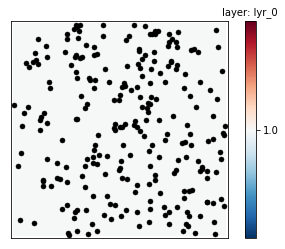

In [55]:
#plot the resulting object
mod.plot(spp=0, lyr=0)

<div class="alert alert-warning" role="alert" style="font-size:120%">
    <b><h2>Run the model</h2></b> 

Geonomics allows us to use our model in either of two ways:

- **'run'**: Run the model to completion(i.e. for the number of iterations and the number of timesteps per iteration that are stipulated in the model's parameters). This is more convenient for leaving a model running and generating data.

- **'walk'**: Run the model for any number of timesteps, then stop it. This is more convenient for running a model interactively and inspecting it. This is what we'll use.


In [56]:
#First we have to run the model burn-in

#T=10000 allows the model run up to 10000 steps, but it will burn in much faster than that.

#After it runs, scroll to the bottom to see how the time steps progressed.

mod.walk(T=10000, mode='burn')




No mod.burn_fn_queue was found. Running mod.reset()...


Creating the burn-in function queue...


Creating the main function queue...


burn:	-1:0
	species: spp_0                         N=250	(births=36	deaths=0)

	........................................................................
burn:	-1:1
	species: spp_0                         N=286	(births=39	deaths=0)

	........................................................................
burn:	-1:2
	species: spp_0                         N=325	(births=45	deaths=0)

	........................................................................
burn:	-1:3
	species: spp_0                         N=370	(births=53	deaths=0)

	........................................................................
burn:	-1:4
	species: spp_0                         N=423	(births=55	deaths=0)

	........................................................................
burn:	-1:5
	species: spp_0                         N=478	(births=74	deaths=0)

	.................

/home/drew/Desktop/stuff/berk/research/projects/sim/geonomics/ops/demography.py:174: RuntimeWarning: divide by zero encountered in true_divide
  d = N_d/N
/home/drew/Desktop/stuff/berk/research/projects/sim/geonomics/ops/demography.py:174: RuntimeWarning: invalid value encountered in true_divide
  d = N_d/N


burn:	-1:7
	species: spp_0                         N=618	(births=99	deaths=11)

	........................................................................
burn:	-1:8
	species: spp_0                         N=706	(births=83	deaths=7)

	........................................................................
burn:	-1:9
	species: spp_0                         N=782	(births=109	deaths=10)

	........................................................................
burn:	-1:10
	species: spp_0                         N=881	(births=121	deaths=33)

	........................................................................
burn:	-1:11
	species: spp_0                         N=969	(births=133	deaths=43)

	........................................................................
burn:	-1:12
	species: spp_0                         N=1059	(births=167	deaths=63)

	........................................................................
burn:	-1:13
	species: spp_0                         N=1163	(births=17

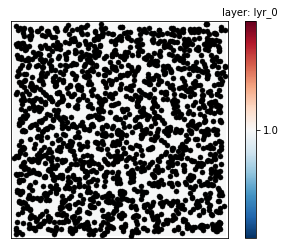

In [57]:
#Now we can plot it again to see the burned-in stable state.
mod.plot(0, 0)



main:	-1:0
	species: spp_0                         N=1797	(births=244	deaths=263)

	........................................................................
main:	-1:1
	species: spp_0                         N=1778	(births=249	deaths=217)

	........................................................................
main:	-1:2
	species: spp_0                         N=1810	(births=252	deaths=254)

	........................................................................
main:	-1:3
	species: spp_0                         N=1808	(births=245	deaths=206)

	........................................................................
main:	-1:4
	species: spp_0                         N=1847	(births=248	deaths=280)

	........................................................................
main:	-1:5
	species: spp_0                         N=1815	(births=254	deaths=273)

	........................................................................
main:	-1:6
	species: spp_0                         N=179

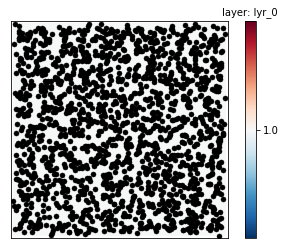

In [58]:
#Now we can run the main phase of the model for any desired number of timesteps, then plot it again.
mod.walk(10, 'main')
mod.plot(0, 0)

<div class="alert alert-warning" role="alert" style="font-size:120%">
    <b><h2>Environmental change</h2></b> 

What would happen if a barrier were to arise on our landscape?

*Let's simulate one, to find out!*

We'll create a layer that's identical to our landscape layer, but has 0's along a NW-SE diagonal barrier.


Now we'll write that array to a file, then create a new parameters file with a landscape change event that uses that file.

In [168]:
#save a new file
barr_lyr = add_vert_barrier(mod.land[0].rast)
np.savetxt('barrier.txt', barr_lyr, fmt='%0.5f')

Then we'll use the same code as before to create a new parameters file (this time with a landscape-change event) and load it into a cell.

You'll tweak it the same as before:

- **dim** parameter: *set the landscape dimensions to __(40, 40)__*

- **rast** parameter: *set the landscape raster to a 40-cell by 40-cell uniform array of ones. We can do this using the function we loaded above as __`make_unif_array(40)`__.*

But this time you'll also set the following parameter values:

- **change_rast** parameter: *set the value of this parameter, in the landscape-change section, to __'./barrier.txt'__*

- **start_t** parameter: *set the landscape-change event to start at timestep __500__*

- **end_t** parameter: *set the landscape-change event to end at timestep __600__*

- **n_steps** parameter: *to keep things simple, set the number of stepwise-changes in the landscape-change event to just __2__*

In [165]:
# create a new Geonomics parameters file, with landscape change

gnx.make_parameters_file(filepath='./barrier_demo.py',
                         layers=[{'type': 'defined', 'change': True}],
                         species=[{'movement': True,
                                   'movement_surface': True,
                                   'dispersal_surface': False,
                                   'genomes': True,
                                   'n_traits': 0,
                                   'demographic_change': 0,
                                   'parameter_change': False}],
                         data=False,
                         stats=False)

In [ ]:
# |||                                 |||
# vvv UNCOMMENT AND RUN THE NEXT LINE vvv

#%load ./barrier_demo.py

In [204]:
# %load ./barrier_demo.py
# barrier_demo.py

# This is a parameters file generated by Geonomics
# (by the gnx.make_parameters_file() function).


                   ##  ::::::          :::    :: ::::::::::##
             ##:::::    ::::   :::      ::    :: :: ::::::::::: :##
          ##::::::::     ::            ::   ::::::::::::::::::::::::##
        ##:::::::::                      :::::::::: :::::: ::::::::  :##
      ## : ::::  ::                    ::::  : ::    :::::::: : ::  :   ##
     ##GGGGG  EEEEE OOOOO   NN   NN   OOOOO   MM   MM IIIIII  CCCCC SSSSS##
    ##GG     EE    OO   OO  NNN  NN  OO   OO  MM   MM   II   CC     SS    ##
    ##GG     EE   OO     OO NN N NN OO     OO MMM MMM   II   CC     SSSSSS##
    ##GG GGG EEEE OO     OO NN  NNN OO     OO MM M MM   II   CC         SS##
    ##GG   G EE    OO   OO  NN   NN  OO   OO  MM   MM   II   CC        SSS##
     ##GGGGG  EEEEE OOOOO   NN   NN   OOOOO   MM   MM IIIIII  CCCCC SSSSS##
      ##    :::::::::               :::::::::: ::              ::  :   :##
        ##:   :::::                    :::::: :::             ::::::: ##
          ##   :::                      :::::  ::              :::::##
             ## ::                      ::::                     ##
                   ##                                      ##
                      ## :: ::    :::            ##


params = {
###############################################################################

###################
#### LANDSCAPE ####
###################
    'landscape': {

    ##############
    #### main ####
    ##############
        'main': {
            #x,y (a.k.a. j,i) dimensions of the Landscape
            'dim':                      (40,40),
            #x,y resolution of the Landscape
            'res':                      (1,1),
            #x,y coords of upper-left corner of the Landscape
            'ulc':                      (0,0),
            #projection of the Landscape
            'prj':                      None,
            }, # <END> 'main'

    ################
    #### layers ####
    ################
        'layers': {

            #layer name (LAYER NAMES MUST BE UNIQUE!)
            'lyr_0': {

        #######################################
        #### layer num. 0: init parameters ####
        #######################################

                #initiating parameters for this layer
                'init': {

                    #parameters for a 'defined'-type Layer
                    'defined': {
                        #raster to use for the Layer
                        'rast':                   make_unif_array(40),
                        #point coordinates
                        'pts':                    None,
                        #point values
                        'vals':                   None,
                        #interpolation method {None, 'linear', 'cubic',
                        #'nearest'}
                        'interp_method':          None,

                        }, # <END> 'defined'

                    }, # <END> 'init'

            #########################################
            #### layer num. 0: change parameters ####
            #########################################

                #landscape-change events for this Layer
                'change': {

                    0: {
                        #array or file for final raster of event, or directory
                        #of files for each stepwise change in event
                        'change_rast':      'barrier.txt',
                        #starting timestep of event
                        'start_t':          500,
                        #ending timestep of event
                        'end_t':            600,
                        #number of stepwise changes in event
                        'n_steps':          2,
                        }, # <END> event 0

                    }, # <END> 'change'

                }, # <END> layer num. 0



    #### NOTE: Individual Layers' sections can be copy-and-pasted (and
    #### assigned distinct keys and names), to create additional Layers.


            } # <END> 'layers'

        }, # <END> 'landscape'


###############################################################################

###################
#### COMMUNITY ####
###################
    'comm': {

        'species': {

            #species name (SPECIES NAMES MUST BE UNIQUE!)
            'spp_0': {

            #####################################
            #### spp num. 0: init parameters ####
            #####################################

                'init': {
                    #starting number of individs
                    'N':                250,
                    #carrying-capacity Layer name
                    'K_layer':          'lyr_0',
                    #multiplicative factor for carrying-capacity layer
                    'K_factor':         1,
                    }, # <END> 'init'

            #######################################
            #### spp num. 0: mating parameters ####
            #######################################

                'mating'    : {
                    #age(s) at sexual maturity (if tuple, female first)
                    'repro_age':                0,
                    #whether to assign sexes
                    'sex':                      False,
                    #ratio of males to females
                    'sex_ratio':                1/1,
                    #whether P(birth) should be weighted by parental dist
                    'dist_weighted_birth':       False,
                    #intrinsic growth rate
                    'R':                        0.5,
                    #intrinsic birth rate (MUST BE 0<=b<=1)
                    'b':                        0.2,
                    #expectation of distr of n offspring per mating pair
                    'n_births_distr_lambda':    1,
                    #whether n births should be fixed at n_births_dist_lambda
                    'n_births_fixed':           True,
                    #radius of mate-search area
                    'mating_radius':            10,
                    }, # <END> 'mating'

            ##########################################
            #### spp num. 0: mortality parameters ####
            ##########################################

                'mortality'     : {
                    #maximum age
                    'max_age':                      None,
                    #min P(death) (MUST BE 0<=d_min<=1)
                    'd_min':                        0,
                    #max P(death) (MUST BE 0<=d_max<=1)
                    'd_max':                        1,
                    #width of window used to estimate local pop density
                    'density_grid_window_width':    None,
                    }, # <END> 'mortality'

            #########################################
            #### spp num. 0: movement parameters ####
            #########################################

                'movement': {
                    #whether or not the species is mobile
                    'move':                     True,
                    #mode of distr of movement direction
                    'direction_distr_mu':       0,
                    #concentration of distr of movement direction
                    'direction_distr_kappa':    0,
                    #mean of distr of movement distance
                    'distance_distr_mu':        0.5,
                    #variance of distr of movement distance
                    'distance_distr_sigma':     0.5,
                    #mean of distr of dispersal distance
                    'dispersal_distr_mu':       0.5,
                    #variance of distr of dispersal distance
                    'dispersal_distr_sigma':    0.5,
                    'move_surf'     : {
                        #move-surf Layer name
                        'layer':                'lyr_0',
                        #whether to use mixture distrs
                        'mixture':              True,
                        #concentration of distrs
                        'vm_distr_kappa':       12,
                        #length of approximation vectors for distrs
                        'approx_len':           5000,
                        }, # <END> 'move_surf'

                    },    # <END> 'movement'


            #####################################################
            #### spp num. 0: genomic architecture parameters ####
            #####################################################

                'gen_arch': {
                    #file defining custom genomic arch
                    'gen_arch_file':            None,
                    #num of loci
                    'L':                        100,
                    #num of chromosomes
                    'l_c':                      [100],
                    #whether starting allele frequencies should be fixed at 0.5
                    'start_p_fixed':            True,
                    #genome-wide per-base neutral mut rate (0 to disable)
                    'mu_neut':                  1e-9,
                    #genome-wide per-base deleterious mut rate (0 to disable)
                    'mu_delet':                 0,
                    #shape of distr of deleterious effect sizes
                    'delet_alpha_distr_shape':  0.2,
                    #scale of distr of deleterious effect sizes
                    'delet_alpha_distr_scale':  0.2,
                    #alpha of distr of recomb rates
                    'r_distr_alpha':            None,
                    #beta of distr of recomb rates
                    'r_distr_beta':             None,
                    #whether loci should be dominant (for allele '1')
                    'dom':                      False,
                    #whether to allow pleiotropy
                    'pleiotropy':               False,
                    #custom fn for drawing recomb rates
                    'recomb_rate_custom_fn':    None,
                    #number of recomb paths to hold in memory
                    'n_recomb_paths_mem':       int(1e4),
                    #total number of recomb paths to simulate
                    'n_recomb_paths_tot':       int(1e5),
                    #whether to generate recombination paths at each timestep
                    'allow_ad_hoc_recomb':       False,
                    #whether to save mutation logs
                    'mut_log':                  False,

                    }, # <END> 'gen_arch'


                }, # <END> spp num. 0



    #### NOTE: individual Species' sections can be copy-and-pasted (and
    #### assigned distinct keys and names), to create additional Species.


            }, # <END> 'species'

        }, # <END> 'comm'


###############################################################################

###############
#### MODEL ####
###############
    'model': {
        #total Model runtime (in timesteps)
        'T':            100,
        #min burn-in runtime (in timesteps)
        'burn_T':       30,
        #seed number
        'num':          None,

        ###############################
        #### iterations parameters ####
        ###############################
        'its': {
            #num iterations
            'n_its':            1,
            #whether to randomize Landscape each iteration
            'rand_landscape':   False,
            #whether to randomize Community each iteration
            'rand_comm':        False,
            #whether to burn in each iteration
            'repeat_burn':      False,
            }, # <END> 'iterations'


        ####################################
        #### data-collection parameters ####
        ####################################
        'data': {
            'sampling': {
                #sampling scheme {'all', 'random', 'point', 'transect'}
                'scheme':               'random',
                #sample size at each point, for point & transect sampling
                'n':                    250,
                #coords of collection points, for point sampling
                'points':               None,
                #coords of transect endpoints, for transect sampling
                'transect_endpoints':   None,
                #num points along transect, for transect sampling
                'n_transect_points':    None,
                #collection radius around points, for point & transect sampling
                'radius':               None,
                #when to collect data
                'when':                 None,
                #whether to save current Layers when data is collected
                'include_landscape':    False,
                #whether to include fixed loci in VCF files
                'include_fixed_sites':  False,
                },
            'format': {
                #format for genetic data {'vcf', 'fasta'}
                'gen_format':           ['vcf', 'fasta'],
                #format for vector geodata {'csv', 'shapefile', 'geojson'}
                'geo_vect_format':      'csv',
                #format for raster geodata {'geotiff', 'txt'}
                'geo_rast_format':      'geotiff',
                },
            }, #<END> 'data'


        #####################################
        #### stats-collection parameters ####
        #####################################
        'stats': {
            #number of individs at time t
            'Nt': {
                #whether to calculate
                'calc':     True,
                #calculation frequency (in timesteps)
                'freq':     1,
                },
            #heterozgosity
            'het': {
                #whether to calculate
                'calc':     True,
                #calculation frequency (in timesteps)
                'freq':     5,
                #whether to mean across sampled individs
                'mean': False,
                },
            #minor allele freq
            'maf': {
                #whether to calculate
                'calc':     True,
                #calculation frequency (in timesteps)
                'freq':     5,
                },
            #mean fitness
            'mean_fit': {
                #whether to calculate
                'calc':     True,
                #calculation frequency (in timesteps)
                'freq':     5,
                },
            #linkage disequilibirum
            'ld': {
                #whether to calculate
                'calc':     False,
                #calculation frequency (in timesteps)
                'freq':     100,
                },
            }, # <END> 'stats'

        } # <END> 'model'

    } # <END> params


Now, just like before, we'll create the model, burn it in, then run it and observe.

In [205]:
#make our params dict into a proper Geonomics ParamsDict object
params = gnx.make_params_dict(params, 'barrier_demo')
#then use it to make a model
mod = gnx.make_model(parameters=params, verbose=True)


MAKING MODEL...

	MAKING LANDSCAPE...

	MAKING COMMUNITY...

		MAKING SPECIES spp_0...

			making genomic architecture...

			making individuals...

			making movement surface...
				[can take a bit]

			setting up species changes...
				[can take a while,
				 if movement or dispersal
				 surfaces will change]





No mod.burn_fn_queue was found. Running mod.reset()...


Creating the burn-in function queue...


Creating the main function queue...


burn:	-1:0
	species: spp_0                         N=250	(births=34	deaths=0)

	........................................................................
burn:	-1:1
	species: spp_0                         N=284	(births=43	deaths=0)

	........................................................................
burn:	-1:2
	species: spp_0                         N=327	(births=39	deaths=0)

	........................................................................
burn:	-1:3
	species: spp_0                         N=366	(births=55	deaths=0)

	........................................................................
burn:	-1:4
	species: spp_0                         N=421	(births=54	deaths=0)

	........................................................................
burn:	-1:5
	species: spp_0                         N=475	(births=67	deaths=0)

	.................

/home/drew/Desktop/stuff/berk/research/projects/sim/geonomics/ops/demography.py:174: RuntimeWarning: divide by zero encountered in true_divide
  d = N_d/N
/home/drew/Desktop/stuff/berk/research/projects/sim/geonomics/ops/demography.py:174: RuntimeWarning: invalid value encountered in true_divide
  d = N_d/N


burn:	-1:6
	species: spp_0                         N=542	(births=73	deaths=2)

	........................................................................
burn:	-1:7
	species: spp_0                         N=613	(births=93	deaths=12)

	........................................................................
burn:	-1:8
	species: spp_0                         N=694	(births=91	deaths=6)

	........................................................................
burn:	-1:9
	species: spp_0                         N=779	(births=103	deaths=23)

	........................................................................
burn:	-1:10
	species: spp_0                         N=859	(births=119	deaths=21)

	........................................................................
burn:	-1:11
	species: spp_0                         N=957	(births=137	deaths=29)

	........................................................................
burn:	-1:12
	species: spp_0                         N=1065	(births=151	de

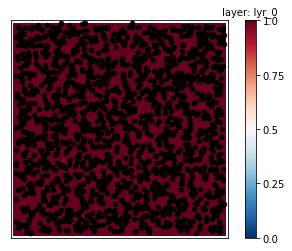

In [206]:
#First we have to run the model burn-in, as always

#SCROLL DOWN TO OBSERVE BURN-IN AND SEE PLOT

mod.walk(T=10000, mode='burn')
#plot the resulting object
mod.plot(spp=0, lyr=0)

In [207]:
#Now we can run the main phase of the model for the first 500 timesteps.
mod.walk(500, 'main')



main:	-1:0
	species: spp_0                         N=1783	(births=227	deaths=243)

	........................................................................
main:	-1:1
	species: spp_0                         N=1767	(births=235	deaths=224)

	........................................................................
main:	-1:2
	species: spp_0                         N=1778	(births=219	deaths=208)

	........................................................................
main:	-1:3
	species: spp_0                         N=1789	(births=266	deaths=234)

	........................................................................
main:	-1:4
	species: spp_0                         N=1821	(births=273	deaths=288)

	........................................................................
main:	-1:5
	species: spp_0                         N=1806	(births=251	deaths=220)

	........................................................................
main:	-1:6
	species: spp_0                         N=183

main:	-1:54
	species: spp_0                         N=1787	(births=240	deaths=236)

	........................................................................
main:	-1:55
	species: spp_0                         N=1791	(births=231	deaths=220)

	........................................................................
main:	-1:56
	species: spp_0                         N=1802	(births=255	deaths=270)

	........................................................................
main:	-1:57
	species: spp_0                         N=1787	(births=259	deaths=247)

	........................................................................
main:	-1:58
	species: spp_0                         N=1799	(births=229	deaths=240)

	........................................................................
main:	-1:59
	species: spp_0                         N=1788	(births=251	deaths=254)

	........................................................................
main:	-1:60
	species: spp_0                         

main:	-1:107
	species: spp_0                         N=1776	(births=259	deaths=225)

	........................................................................
main:	-1:108
	species: spp_0                         N=1810	(births=218	deaths=231)

	........................................................................
main:	-1:109
	species: spp_0                         N=1797	(births=290	deaths=266)

	........................................................................
main:	-1:110
	species: spp_0                         N=1821	(births=263	deaths=280)

	........................................................................
main:	-1:111
	species: spp_0                         N=1804	(births=252	deaths=257)

	........................................................................
main:	-1:112
	species: spp_0                         N=1799	(births=236	deaths=213)

	........................................................................
main:	-1:113
	species: spp_0                  

main:	-1:160
	species: spp_0                         N=1777	(births=233	deaths=235)

	........................................................................
main:	-1:161
	species: spp_0                         N=1775	(births=228	deaths=202)

	........................................................................
main:	-1:162
	species: spp_0                         N=1801	(births=267	deaths=258)

	........................................................................
main:	-1:163
	species: spp_0                         N=1810	(births=240	deaths=233)

	........................................................................
main:	-1:164
	species: spp_0                         N=1817	(births=241	deaths=277)

	........................................................................
main:	-1:165
	species: spp_0                         N=1781	(births=240	deaths=222)

	........................................................................
main:	-1:166
	species: spp_0                  

main:	-1:213
	species: spp_0                         N=1841	(births=237	deaths=288)

	........................................................................
main:	-1:214
	species: spp_0                         N=1790	(births=240	deaths=235)

	........................................................................
main:	-1:215
	species: spp_0                         N=1795	(births=236	deaths=238)

	........................................................................
main:	-1:216
	species: spp_0                         N=1793	(births=239	deaths=210)

	........................................................................
main:	-1:217
	species: spp_0                         N=1822	(births=247	deaths=288)

	........................................................................
main:	-1:218
	species: spp_0                         N=1781	(births=253	deaths=224)

	........................................................................
main:	-1:219
	species: spp_0                  

main:	-1:267
	species: spp_0                         N=1812	(births=252	deaths=272)

	........................................................................
main:	-1:268
	species: spp_0                         N=1792	(births=258	deaths=256)

	........................................................................
main:	-1:269
	species: spp_0                         N=1794	(births=252	deaths=253)

	........................................................................
main:	-1:270
	species: spp_0                         N=1793	(births=240	deaths=246)

	........................................................................
main:	-1:271
	species: spp_0                         N=1787	(births=237	deaths=234)

	........................................................................
main:	-1:272
	species: spp_0                         N=1790	(births=238	deaths=266)

	........................................................................
main:	-1:273
	species: spp_0                  

main:	-1:320
	species: spp_0                         N=1815	(births=262	deaths=271)

	........................................................................
main:	-1:321
	species: spp_0                         N=1806	(births=221	deaths=248)

	........................................................................
main:	-1:322
	species: spp_0                         N=1779	(births=256	deaths=233)

	........................................................................
main:	-1:323
	species: spp_0                         N=1802	(births=246	deaths=274)

	........................................................................
main:	-1:324
	species: spp_0                         N=1774	(births=244	deaths=219)

	........................................................................
main:	-1:325
	species: spp_0                         N=1799	(births=241	deaths=206)

	........................................................................
main:	-1:326
	species: spp_0                  

main:	-1:373
	species: spp_0                         N=1802	(births=261	deaths=243)

	........................................................................
main:	-1:374
	species: spp_0                         N=1820	(births=264	deaths=256)

	........................................................................
main:	-1:375
	species: spp_0                         N=1828	(births=226	deaths=238)

	........................................................................
main:	-1:376
	species: spp_0                         N=1816	(births=262	deaths=239)

	........................................................................
main:	-1:377
	species: spp_0                         N=1839	(births=240	deaths=274)

	........................................................................
main:	-1:378
	species: spp_0                         N=1805	(births=255	deaths=251)

	........................................................................
main:	-1:379
	species: spp_0                  

main:	-1:425
	species: spp_0                         N=1795	(births=227	deaths=231)

	........................................................................
main:	-1:426
	species: spp_0                         N=1791	(births=264	deaths=247)

	........................................................................
main:	-1:427
	species: spp_0                         N=1808	(births=263	deaths=264)

	........................................................................
main:	-1:428
	species: spp_0                         N=1807	(births=235	deaths=238)

	........................................................................
main:	-1:429
	species: spp_0                         N=1804	(births=242	deaths=233)

	........................................................................
main:	-1:430
	species: spp_0                         N=1813	(births=271	deaths=238)

	........................................................................
main:	-1:431
	species: spp_0                  

main:	-1:478
	species: spp_0                         N=1814	(births=259	deaths=263)

	........................................................................
main:	-1:479
	species: spp_0                         N=1810	(births=243	deaths=243)

	........................................................................
main:	-1:480
	species: spp_0                         N=1810	(births=252	deaths=271)

	........................................................................
main:	-1:481
	species: spp_0                         N=1791	(births=248	deaths=228)

	........................................................................
main:	-1:482
	species: spp_0                         N=1811	(births=239	deaths=244)

	........................................................................
main:	-1:483
	species: spp_0                         N=1806	(births=253	deaths=263)

	........................................................................
main:	-1:484
	species: spp_0                  

Then let's plot the individuals in "genetic-relatedness space",
and also map them in geographic space but colored by their genetic relatedness.

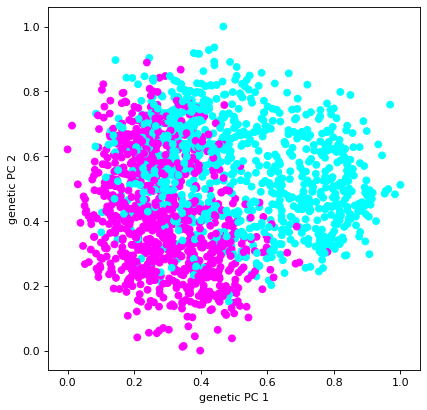

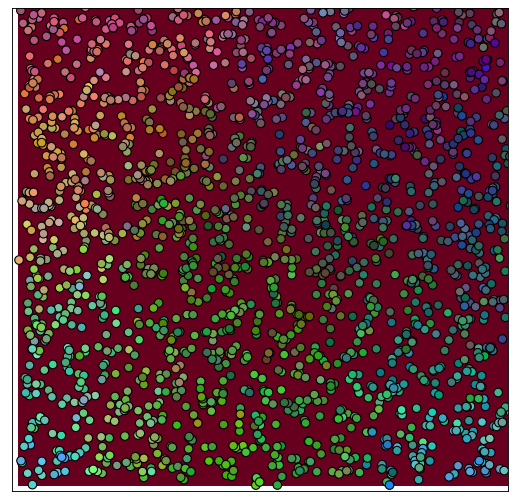

In [218]:
#We'll use the genetic PCA functions we defined at the beginning.
plot_PCA(mod)
map_PCA(mod)

/home/drew/Desktop/stuff/berk/research/projects/sim/geonomics/ops/demography.py:174: RuntimeWarning: divide by zero encountered in true_divide
  d = N_d/N
/home/drew/Desktop/stuff/berk/research/projects/sim/geonomics/ops/demography.py:174: RuntimeWarning: invalid value encountered in true_divide
  d = N_d/N


	**** Running the next change	(500, <function _get_lyr_change_fn.<locals>.fn at 0x7efe95609560>)


	**** Running the next change	(500, <function _get_conductance_surface_change_fns.<locals>.fn at 0x7efe911c8830>)


main:	-1:500
	species: spp_0                         N=968	(births=146	deaths=136)

	........................................................................
main:	-1:501
	species: spp_0                         N=978	(births=141	deaths=209)

	........................................................................
main:	-1:502
	species: spp_0                         N=910	(births=120	deaths=124)

	........................................................................
main:	-1:503
	species: spp_0                         N=906	(births=145	deaths=133)

	........................................................................
main:	-1:504
	species: spp_0                         N=918	(births=107	deaths=111)

	....................................................................

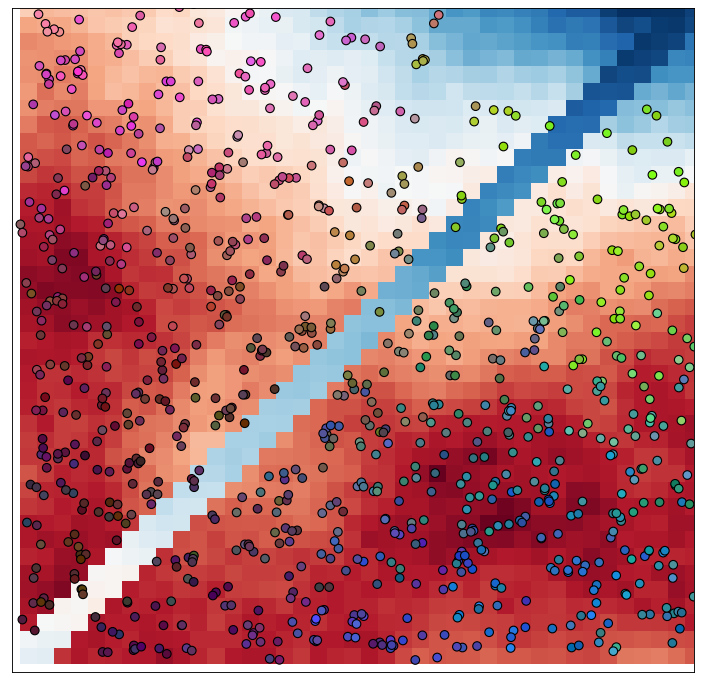

In [74]:
#Then we can run the main phase of the model for the next 50 timesteps, then plot it,
#to see what is happening part-way through the landscape-change event.
mod.walk(50, 'main')




	**** Running the next change	(500, <function _get_lyr_change_fn.<locals>.fn at 0x7f52e9610830>)


	**** Running the next change	(500, <function _get_conductance_surface_change_fns.<locals>.fn at 0x7f52eb4d80e0>)


main:	-1:500
	species: spp_0                         N=1807	(births=261	deaths=265)

	........................................................................
main:	-1:501
	species: spp_0                         N=1803	(births=228	deaths=398)

	........................................................................
main:	-1:502
	species: spp_0                         N=1633	(births=223	deaths=231)

	........................................................................
main:	-1:503
	species: spp_0                         N=1625	(births=238	deaths=206)

	........................................................................
main:	-1:504
	species: spp_0                         N=1657	(births=240	deaths=220)

	.............................................................

/home/drew/Desktop/stuff/berk/research/projects/sim/geonomics/ops/demography.py:174: RuntimeWarning: invalid value encountered in true_divide
  d = N_d/N


main:	-1:521
	species: spp_0                         N=1670	(births=230	deaths=245)

	........................................................................
main:	-1:522
	species: spp_0                         N=1655	(births=235	deaths=252)

	........................................................................
main:	-1:523
	species: spp_0                         N=1638	(births=215	deaths=222)

	........................................................................
main:	-1:524
	species: spp_0                         N=1631	(births=241	deaths=212)

	........................................................................
main:	-1:525
	species: spp_0                         N=1660	(births=222	deaths=226)

	........................................................................
main:	-1:526
	species: spp_0                         N=1656	(births=239	deaths=230)

	........................................................................
main:	-1:527
	species: spp_0                  

/home/drew/Desktop/stuff/berk/research/projects/sim/geonomics/ops/demography.py:174: RuntimeWarning: divide by zero encountered in true_divide
  d = N_d/N


main:	-1:537
	species: spp_0                         N=1652	(births=247	deaths=253)

	........................................................................
main:	-1:538
	species: spp_0                         N=1646	(births=220	deaths=227)

	........................................................................
main:	-1:539
	species: spp_0                         N=1639	(births=226	deaths=218)

	........................................................................
main:	-1:540
	species: spp_0                         N=1647	(births=209	deaths=219)

	........................................................................
main:	-1:541
	species: spp_0                         N=1637	(births=212	deaths=180)

	........................................................................
main:	-1:542
	species: spp_0                         N=1669	(births=208	deaths=251)

	........................................................................
main:	-1:543
	species: spp_0                  

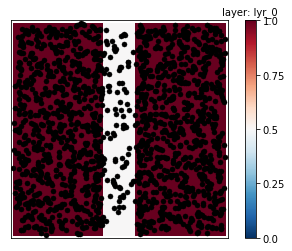

In [219]:
#Now we'll run it for 51 more timesteps, until right after the end of the change event.
mod.walk(51, 'main')
mod.plot(spp=0, lyr=0)



	**** Running the next change	(500, <function _get_lyr_change_fn.<locals>.fn at 0x7f52e9610830>)


	**** Running the next change	(500, <function _get_conductance_surface_change_fns.<locals>.fn at 0x7f52eb4d80e0>)


main:	-1:500
	species: spp_0                         N=1807	(births=261	deaths=265)

	........................................................................
main:	-1:501
	species: spp_0                         N=1803	(births=228	deaths=398)

	........................................................................
main:	-1:502
	species: spp_0                         N=1633	(births=223	deaths=231)

	........................................................................
main:	-1:503
	species: spp_0                         N=1625	(births=238	deaths=206)

	........................................................................
main:	-1:504
	species: spp_0                         N=1657	(births=240	deaths=220)

	.............................................................

/home/drew/Desktop/stuff/berk/research/projects/sim/geonomics/ops/demography.py:174: RuntimeWarning: invalid value encountered in true_divide
  d = N_d/N


main:	-1:521
	species: spp_0                         N=1670	(births=230	deaths=245)

	........................................................................
main:	-1:522
	species: spp_0                         N=1655	(births=235	deaths=252)

	........................................................................
main:	-1:523
	species: spp_0                         N=1638	(births=215	deaths=222)

	........................................................................
main:	-1:524
	species: spp_0                         N=1631	(births=241	deaths=212)

	........................................................................
main:	-1:525
	species: spp_0                         N=1660	(births=222	deaths=226)

	........................................................................
main:	-1:526
	species: spp_0                         N=1656	(births=239	deaths=230)

	........................................................................
main:	-1:527
	species: spp_0                  

/home/drew/Desktop/stuff/berk/research/projects/sim/geonomics/ops/demography.py:174: RuntimeWarning: divide by zero encountered in true_divide
  d = N_d/N


main:	-1:537
	species: spp_0                         N=1652	(births=247	deaths=253)

	........................................................................
main:	-1:538
	species: spp_0                         N=1646	(births=220	deaths=227)

	........................................................................
main:	-1:539
	species: spp_0                         N=1639	(births=226	deaths=218)

	........................................................................
main:	-1:540
	species: spp_0                         N=1647	(births=209	deaths=219)

	........................................................................
main:	-1:541
	species: spp_0                         N=1637	(births=212	deaths=180)

	........................................................................
main:	-1:542
	species: spp_0                         N=1669	(births=208	deaths=251)

	........................................................................
main:	-1:543
	species: spp_0                  

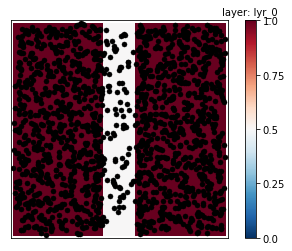

In [219]:
#Now we'll run it for 51 more timesteps, until after the first stage of the change event.
mod.walk(51, 'main')
mod.plot(spp=0, lyr=0)

In [220]:
#Then we'll run it for 50 more timesteps, until after the end of the change event.
mod.walk(50, 'main')
mod.plot(spp=0, lyr=0)



main:	-1:551
	species: spp_0                         N=1685	(births=228	deaths=225)

	........................................................................
main:	-1:552
	species: spp_0                         N=1688	(births=240	deaths=247)

	........................................................................
main:	-1:553
	species: spp_0                         N=1681	(births=216	deaths=237)

	........................................................................
main:	-1:554
	species: spp_0                         N=1660	(births=241	deaths=237)

	........................................................................
main:	-1:555
	species: spp_0                         N=1664	(births=251	deaths=225)

	........................................................................
main:	-1:556
	species: spp_0                         N=1690	(births=207	deaths=244)

	........................................................................
main:	-1:557
	species: spp_0                

main:	-1:603
	species: spp_0                         N=1588	(births=222	deaths=219)

	........................................................................
main:	-1:604
	species: spp_0                         N=1591	(births=240	deaths=289)

	........................................................................
main:	-1:605
	species: spp_0                         N=1542	(births=235	deaths=206)

	........................................................................
main:	-1:606
	species: spp_0                         N=1571	(births=215	deaths=235)

	........................................................................
main:	-1:607
	species: spp_0                         N=1551	(births=221	deaths=201)

	........................................................................
main:	-1:608
	species: spp_0                         N=1571	(births=225	deaths=224)

	........................................................................
main:	-1:609
	species: spp_0                  

main:	-1:657
	species: spp_0                         N=1530	(births=201	deaths=185)

	........................................................................
main:	-1:658
	species: spp_0                         N=1546	(births=235	deaths=212)

	........................................................................
main:	-1:659
	species: spp_0                         N=1569	(births=215	deaths=195)

	........................................................................
main:	-1:660
	species: spp_0                         N=1589	(births=222	deaths=249)

	........................................................................
main:	-1:661
	species: spp_0                         N=1562	(births=236	deaths=220)

	........................................................................
main:	-1:662
	species: spp_0                         N=1578	(births=233	deaths=227)

	........................................................................
main:	-1:663
	species: spp_0                  

main:	-1:709
	species: spp_0                         N=1559	(births=200	deaths=216)

	........................................................................
main:	-1:710
	species: spp_0                         N=1543	(births=223	deaths=211)

	........................................................................
main:	-1:711
	species: spp_0                         N=1555	(births=228	deaths=220)

	........................................................................
main:	-1:712
	species: spp_0                         N=1563	(births=217	deaths=224)

	........................................................................
main:	-1:713
	species: spp_0                         N=1556	(births=229	deaths=212)

	........................................................................
main:	-1:714
	species: spp_0                         N=1573	(births=223	deaths=241)

	........................................................................
main:	-1:715
	species: spp_0                  

ValueError: RGBA sequence should have length 3 or 4

ValueError: RGBA sequence should have length 3 or 4

<Figure size 432x288 with 1 Axes>

Then let's plot genetic relatedness again.

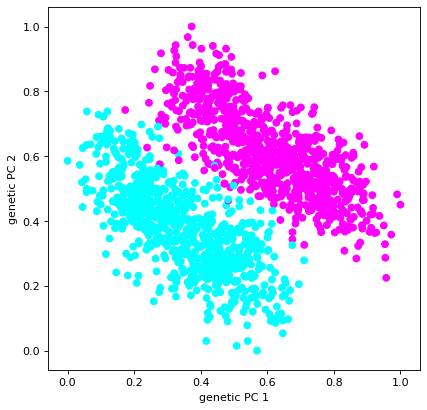

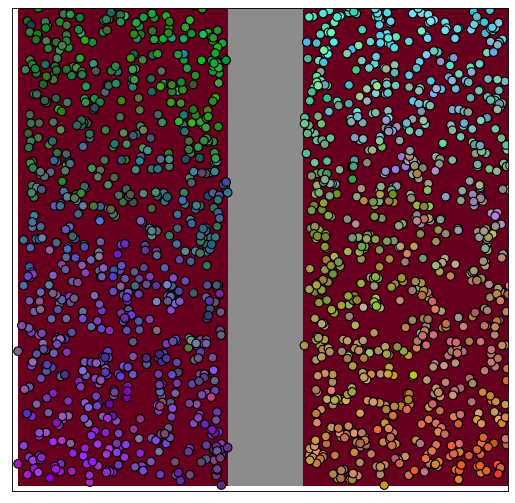

In [221]:
plot_PCA(mod)
map_PCA(mod)

Finally, we'll run the model for another 500 time steps, then plot genetic relatedness once more.

In [224]:
mod.walk(500, 'main')



main:	-1:1251
	species: spp_0                         N=1548	(births=220	deaths=193)

	........................................................................
main:	-1:1252
	species: spp_0                         N=1575	(births=241	deaths=255)

	........................................................................


/home/drew/Desktop/stuff/berk/research/projects/sim/geonomics/ops/demography.py:174: RuntimeWarning: divide by zero encountered in true_divide
  d = N_d/N


main:	-1:1253
	species: spp_0                         N=1561	(births=231	deaths=238)

	........................................................................
main:	-1:1254
	species: spp_0                         N=1554	(births=212	deaths=198)

	........................................................................
main:	-1:1255
	species: spp_0                         N=1568	(births=203	deaths=212)

	........................................................................
main:	-1:1256
	species: spp_0                         N=1559	(births=226	deaths=203)

	........................................................................
main:	-1:1257
	species: spp_0                         N=1582	(births=220	deaths=248)

	........................................................................
main:	-1:1258
	species: spp_0                         N=1554	(births=217	deaths=228)

	........................................................................
main:	-1:1259
	species: spp_0           

main:	-1:1305
	species: spp_0                         N=1543	(births=233	deaths=223)

	........................................................................
main:	-1:1306
	species: spp_0                         N=1553	(births=223	deaths=193)

	........................................................................
main:	-1:1307
	species: spp_0                         N=1583	(births=223	deaths=221)

	........................................................................
main:	-1:1308
	species: spp_0                         N=1585	(births=221	deaths=228)

	........................................................................
main:	-1:1309
	species: spp_0                         N=1578	(births=232	deaths=214)

	........................................................................
main:	-1:1310
	species: spp_0                         N=1596	(births=214	deaths=227)

	........................................................................
main:	-1:1311
	species: spp_0           

main:	-1:1359
	species: spp_0                         N=1564	(births=210	deaths=231)

	........................................................................
main:	-1:1360
	species: spp_0                         N=1543	(births=229	deaths=202)

	........................................................................
main:	-1:1361
	species: spp_0                         N=1570	(births=228	deaths=217)

	........................................................................
main:	-1:1362
	species: spp_0                         N=1581	(births=229	deaths=229)

	........................................................................
main:	-1:1363
	species: spp_0                         N=1581	(births=198	deaths=236)

	........................................................................
main:	-1:1364
	species: spp_0                         N=1543	(births=219	deaths=214)

	........................................................................
main:	-1:1365
	species: spp_0           

main:	-1:1413
	species: spp_0                         N=1583	(births=225	deaths=261)

	........................................................................
main:	-1:1414
	species: spp_0                         N=1547	(births=209	deaths=199)

	........................................................................
main:	-1:1415
	species: spp_0                         N=1557	(births=207	deaths=226)

	........................................................................
main:	-1:1416
	species: spp_0                         N=1538	(births=196	deaths=192)

	........................................................................
main:	-1:1417
	species: spp_0                         N=1542	(births=199	deaths=232)

	........................................................................
main:	-1:1418
	species: spp_0                         N=1509	(births=219	deaths=187)

	........................................................................
main:	-1:1419
	species: spp_0           

main:	-1:1466
	species: spp_0                         N=1571	(births=213	deaths=226)

	........................................................................
main:	-1:1467
	species: spp_0                         N=1558	(births=237	deaths=245)

	........................................................................
main:	-1:1468
	species: spp_0                         N=1550	(births=208	deaths=206)

	........................................................................
main:	-1:1469
	species: spp_0                         N=1552	(births=211	deaths=205)

	........................................................................
main:	-1:1470
	species: spp_0                         N=1558	(births=210	deaths=218)

	........................................................................
main:	-1:1471
	species: spp_0                         N=1550	(births=203	deaths=186)

	........................................................................
main:	-1:1472
	species: spp_0           

main:	-1:1518
	species: spp_0                         N=1542	(births=202	deaths=200)

	........................................................................
main:	-1:1519
	species: spp_0                         N=1544	(births=201	deaths=221)

	........................................................................
main:	-1:1520
	species: spp_0                         N=1524	(births=218	deaths=204)

	........................................................................
main:	-1:1521
	species: spp_0                         N=1538	(births=243	deaths=211)

	........................................................................
main:	-1:1522
	species: spp_0                         N=1570	(births=218	deaths=204)

	........................................................................
main:	-1:1523
	species: spp_0                         N=1584	(births=216	deaths=206)

	........................................................................
main:	-1:1524
	species: spp_0           

main:	-1:1571
	species: spp_0                         N=1537	(births=220	deaths=211)

	........................................................................
main:	-1:1572
	species: spp_0                         N=1546	(births=213	deaths=196)

	........................................................................
main:	-1:1573
	species: spp_0                         N=1563	(births=212	deaths=188)

	........................................................................
main:	-1:1574
	species: spp_0                         N=1587	(births=212	deaths=232)

	........................................................................
main:	-1:1575
	species: spp_0                         N=1567	(births=224	deaths=225)

	........................................................................
main:	-1:1576
	species: spp_0                         N=1566	(births=195	deaths=220)

	........................................................................
main:	-1:1577
	species: spp_0           

main:	-1:1623
	species: spp_0                         N=1529	(births=209	deaths=212)

	........................................................................
main:	-1:1624
	species: spp_0                         N=1526	(births=218	deaths=191)

	........................................................................
main:	-1:1625
	species: spp_0                         N=1553	(births=184	deaths=214)

	........................................................................
main:	-1:1626
	species: spp_0                         N=1523	(births=194	deaths=177)

	........................................................................
main:	-1:1627
	species: spp_0                         N=1540	(births=221	deaths=208)

	........................................................................
main:	-1:1628
	species: spp_0                         N=1553	(births=218	deaths=195)

	........................................................................
main:	-1:1629
	species: spp_0           

main:	-1:1675
	species: spp_0                         N=1559	(births=212	deaths=200)

	........................................................................
main:	-1:1676
	species: spp_0                         N=1571	(births=228	deaths=215)

	........................................................................
main:	-1:1677
	species: spp_0                         N=1584	(births=242	deaths=251)

	........................................................................
main:	-1:1678
	species: spp_0                         N=1575	(births=240	deaths=230)

	........................................................................
main:	-1:1679
	species: spp_0                         N=1585	(births=221	deaths=237)

	........................................................................
main:	-1:1680
	species: spp_0                         N=1569	(births=236	deaths=235)

	........................................................................
main:	-1:1681
	species: spp_0           

main:	-1:1728
	species: spp_0                         N=1562	(births=216	deaths=229)

	........................................................................
main:	-1:1729
	species: spp_0                         N=1549	(births=216	deaths=203)

	........................................................................
main:	-1:1730
	species: spp_0                         N=1562	(births=217	deaths=222)

	........................................................................
main:	-1:1731
	species: spp_0                         N=1557	(births=219	deaths=235)

	........................................................................
main:	-1:1732
	species: spp_0                         N=1541	(births=205	deaths=200)

	........................................................................
main:	-1:1733
	species: spp_0                         N=1546	(births=219	deaths=206)

	........................................................................
main:	-1:1734
	species: spp_0           

main:	-1:1781
	species: spp_0                         N=1580	(births=236	deaths=201)

	........................................................................
main:	-1:1782
	species: spp_0                         N=1615	(births=215	deaths=253)

	........................................................................
main:	-1:1783
	species: spp_0                         N=1577	(births=205	deaths=242)

	........................................................................
main:	-1:1784
	species: spp_0                         N=1540	(births=225	deaths=198)

	........................................................................
main:	-1:1785
	species: spp_0                         N=1567	(births=215	deaths=216)

	........................................................................
main:	-1:1786
	species: spp_0                         N=1566	(births=211	deaths=220)

	........................................................................
main:	-1:1787
	species: spp_0           

main:	-1:1834
	species: spp_0                         N=1557	(births=210	deaths=220)

	........................................................................
main:	-1:1835
	species: spp_0                         N=1547	(births=230	deaths=226)

	........................................................................
main:	-1:1836
	species: spp_0                         N=1551	(births=189	deaths=183)

	........................................................................
main:	-1:1837
	species: spp_0                         N=1557	(births=231	deaths=210)

	........................................................................
main:	-1:1838
	species: spp_0                         N=1578	(births=211	deaths=229)

	........................................................................
main:	-1:1839
	species: spp_0                         N=1560	(births=214	deaths=196)

	........................................................................
main:	-1:1840
	species: spp_0           

main:	-1:1888
	species: spp_0                         N=1544	(births=204	deaths=202)

	........................................................................
main:	-1:1889
	species: spp_0                         N=1546	(births=205	deaths=196)

	........................................................................
main:	-1:1890
	species: spp_0                         N=1555	(births=223	deaths=232)

	........................................................................
main:	-1:1891
	species: spp_0                         N=1546	(births=235	deaths=219)

	........................................................................
main:	-1:1892
	species: spp_0                         N=1562	(births=210	deaths=190)

	........................................................................
main:	-1:1893
	species: spp_0                         N=1582	(births=181	deaths=222)

	........................................................................
main:	-1:1894
	species: spp_0           

main:	-1:1941
	species: spp_0                         N=1586	(births=222	deaths=228)

	........................................................................
main:	-1:1942
	species: spp_0                         N=1580	(births=228	deaths=238)

	........................................................................
main:	-1:1943
	species: spp_0                         N=1570	(births=228	deaths=240)

	........................................................................
main:	-1:1944
	species: spp_0                         N=1558	(births=240	deaths=231)

	........................................................................
main:	-1:1945
	species: spp_0                         N=1567	(births=207	deaths=209)

	........................................................................
main:	-1:1946
	species: spp_0                         N=1565	(births=215	deaths=238)

	........................................................................
main:	-1:1947
	species: spp_0           

main:	-1:1993
	species: spp_0                         N=1550	(births=220	deaths=199)

	........................................................................
main:	-1:1994
	species: spp_0                         N=1571	(births=240	deaths=211)

	........................................................................
main:	-1:1995
	species: spp_0                         N=1600	(births=222	deaths=249)

	........................................................................
main:	-1:1996
	species: spp_0                         N=1573	(births=226	deaths=239)

	........................................................................
main:	-1:1997
	species: spp_0                         N=1560	(births=232	deaths=194)

	........................................................................
main:	-1:1998
	species: spp_0                         N=1598	(births=228	deaths=225)

	........................................................................
main:	-1:1999
	species: spp_0           

main:	-1:2047
	species: spp_0                         N=1571	(births=210	deaths=229)

	........................................................................
main:	-1:2048
	species: spp_0                         N=1552	(births=235	deaths=229)

	........................................................................
main:	-1:2049
	species: spp_0                         N=1558	(births=203	deaths=195)

	........................................................................
main:	-1:2050
	species: spp_0                         N=1566	(births=215	deaths=218)

	........................................................................
main:	-1:2051
	species: spp_0                         N=1563	(births=221	deaths=215)

	........................................................................
main:	-1:2052
	species: spp_0                         N=1569	(births=204	deaths=198)

	........................................................................
main:	-1:2053
	species: spp_0           

main:	-1:2100
	species: spp_0                         N=1552	(births=223	deaths=207)

	........................................................................
main:	-1:2101
	species: spp_0                         N=1568	(births=216	deaths=243)

	........................................................................
main:	-1:2102
	species: spp_0                         N=1541	(births=221	deaths=215)

	........................................................................
main:	-1:2103
	species: spp_0                         N=1547	(births=205	deaths=199)

	........................................................................
main:	-1:2104
	species: spp_0                         N=1553	(births=212	deaths=204)

	........................................................................
main:	-1:2105
	species: spp_0                         N=1561	(births=191	deaths=213)

	........................................................................
main:	-1:2106
	species: spp_0           

main:	-1:2152
	species: spp_0                         N=1543	(births=215	deaths=183)

	........................................................................
main:	-1:2153
	species: spp_0                         N=1575	(births=196	deaths=233)

	........................................................................
main:	-1:2154
	species: spp_0                         N=1538	(births=208	deaths=178)

	........................................................................
main:	-1:2155
	species: spp_0                         N=1568	(births=229	deaths=237)

	........................................................................
main:	-1:2156
	species: spp_0                         N=1560	(births=227	deaths=209)

	........................................................................
main:	-1:2157
	species: spp_0                         N=1578	(births=245	deaths=227)

	........................................................................
main:	-1:2158
	species: spp_0           

main:	-1:2206
	species: spp_0                         N=1551	(births=204	deaths=215)

	........................................................................
main:	-1:2207
	species: spp_0                         N=1540	(births=198	deaths=190)

	........................................................................
main:	-1:2208
	species: spp_0                         N=1548	(births=219	deaths=223)

	........................................................................
main:	-1:2209
	species: spp_0                         N=1544	(births=183	deaths=199)

	........................................................................
main:	-1:2210
	species: spp_0                         N=1528	(births=219	deaths=212)

	........................................................................
main:	-1:2211
	species: spp_0                         N=1535	(births=224	deaths=215)

	........................................................................
main:	-1:2212
	species: spp_0           

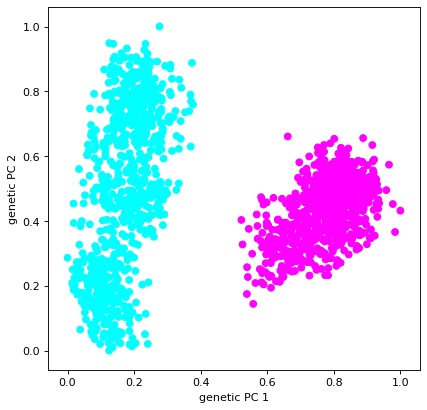

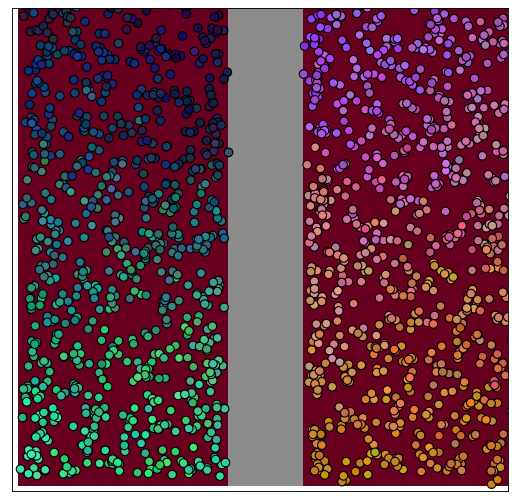

In [225]:
plot_PCA(mod)
map_PCA(mod)

<div class="alert alert-danger" role="alert" style="font-size:120%">
    <b><h2>Neutral evolution</h2></b> 

For the remainder of today's lab, we'll explore a different simulation scenario, one in which natural selection is operating.

The following cells' code are very similar to what we saw in the first section. As before, run the code, changing any values as directed.


<div class="alert alert-warning" role="alert" style="font-size:120%">
    <b><h2>Create a parameters file</h2></b> 

This time, we want a model with <u>__two layers__</u>:

1. A layer to describe the __distribution of habitat__, which will determine both the species' local population density and its movement throughout the landscape. 
    - We will use uniform array for this layer, as we saw in the previous simulation.
2. A layer to describe an __environmental gradient__ across the landscape, which will exert spatially divergent selection on the species.
    - We will define this layer's array using the function that we defined at the beginning of the file.
    
We again want a model with a <u>__single species__</u>, but this time that species should have a __one trait__. Each individual's phenotype for this trait will determined by its genotype at the genetic loci that underlie the trait, and its fitness (i.e. probability of survival) will be determined by the difference between that phenotype and the optimal phenotype at the individual's location, according to the environmental gradient layer. Thus, the environmental gradient will exert spatially divergent natural selection on this trait.

Here is the code to create the parameters file:

In [227]:
# create a Geonomics parameters file

gnx.make_parameters_file(filepath='./selection_demo.py',
                         layers=[{'type': 'defined', 'change': False},
                                 {'type': 'defined', 'change': False}],
                         species=[{'movement': True,
                                   'movement_surface': True,
                                   'dispersal_surface': False,
                                   'genomes': True,
                                   'n_traits': 1,
                                   'demographic_change': 0,
                                   'parameter_change': False}],
                         data=False,
                         stats=False)


<div class="alert alert-warning" role="alert" style="font-size:120%">
    <b><h2>Load and edit the parameters file</h2></b> 

Again, as before, we'll load the parameters file into a cell. (To do that, uncomment the appropriate line of code in the next cell, then run the cell.)


Then, change the following parameter values in the parameters:

- **dim** parameter: *set the landscape dimensions to __(40, 40)__*

- **rast** parameter in the __'lyr_0'__ section: *set to a a horizontal gradient, using __`make_horz_grad_array(40)`__*

- **rast** parameter in the __'lyr_1'__ section: *set to a uniform array, using __`make_unif_array(40)`__*

- **layer** parameter in the __'trait_0'__ section: *set to __`'lyr_1'`__, to indicate that layer 1 should serve as trait 0's selective force*


Finally, run the parameters cell.

In [ ]:
# |||                                 |||
# vvv UNCOMMENT AND RUN THE NEXT LINE vvv

#%load ./selection_demo.py

In [263]:
# %load ./selection_demo.py
# selection_demo.py

# This is a parameters file generated by Geonomics
# (by the gnx.make_parameters_file() function).


                   ##  ::::::          :::    :: ::::::::::##
             ##:::::    ::::   :::      ::    :: :: ::::::::::: :##
          ##::::::::     ::            ::   ::::::::::::::::::::::::##
        ##:::::::::                      :::::::::: :::::: ::::::::  :##
      ## : ::::  ::                    ::::  : ::    :::::::: : ::  :   ##
     ##GGGGG  EEEEE OOOOO   NN   NN   OOOOO   MM   MM IIIIII  CCCCC SSSSS##
    ##GG     EE    OO   OO  NNN  NN  OO   OO  MM   MM   II   CC     SS    ##
    ##GG     EE   OO     OO NN N NN OO     OO MMM MMM   II   CC     SSSSSS##
    ##GG GGG EEEE OO     OO NN  NNN OO     OO MM M MM   II   CC         SS##
    ##GG   G EE    OO   OO  NN   NN  OO   OO  MM   MM   II   CC        SSS##
     ##GGGGG  EEEEE OOOOO   NN   NN   OOOOO   MM   MM IIIIII  CCCCC SSSSS##
      ##    :::::::::               :::::::::: ::              ::  :   :##
        ##:   :::::                    :::::: :::             ::::::: ##
          ##   :::                      :::::  ::              :::::##
             ## ::                      ::::                     ##
                   ##                                      ##
                      ## :: ::    :::            ##


params = {
###############################################################################

###################
#### LANDSCAPE ####
###################
    'landscape': {

    ##############
    #### main ####
    ##############
        'main': {
            #x,y (a.k.a. j,i) dimensions of the Landscape
            'dim':                      (40,40),
            #x,y resolution of the Landscape
            'res':                      (1,1),
            #x,y coords of upper-left corner of the Landscape
            'ulc':                      (0,0),
            #projection of the Landscape
            'prj':                      None,
            }, # <END> 'main'

    ################
    #### layers ####
    ################
        'layers': {

            #layer name (LAYER NAMES MUST BE UNIQUE!)
            'lyr_0': {

        #######################################
        #### layer num. 0: init parameters ####
        #######################################

                #initiating parameters for this layer
                'init': {

                    #parameters for a 'defined'-type Layer
                    'defined': {
                        #raster to use for the Layer
                        'rast':                   make_unif_array(40),
                        #point coordinates
                        'pts':                    None,
                        #point values
                        'vals':                   None,
                        #interpolation method {None, 'linear', 'cubic',
                        #'nearest'}
                        'interp_method':          None,

                        }, # <END> 'defined'

                    }, # <END> 'init'

                }, # <END> layer num. 0


            #layer name (LAYER NAMES MUST BE UNIQUE!)
            'lyr_1': {

        #######################################
        #### layer num. 1: init parameters ####
        #######################################

                #initiating parameters for this layer
                'init': {

                    #parameters for a 'defined'-type Layer
                    'defined': {
                        #raster to use for the Layer
                        'rast':                   make_horz_grad_array(40),
                        #point coordinates
                        'pts':                    None,
                        #point values
                        'vals':                   None,
                        #interpolation method {None, 'linear', 'cubic',
                        #'nearest'}
                        'interp_method':          None,

                        }, # <END> 'defined'

                    }, # <END> 'init'

                }, # <END> layer num. 1



    #### NOTE: Individual Layers' sections can be copy-and-pasted (and
    #### assigned distinct keys and names), to create additional Layers.


            } # <END> 'layers'

        }, # <END> 'landscape'


###############################################################################

###################
#### COMMUNITY ####
###################
    'comm': {

        'species': {

            #species name (SPECIES NAMES MUST BE UNIQUE!)
            'spp_0': {

            #####################################
            #### spp num. 0: init parameters ####
            #####################################

                'init': {
                    #starting number of individs
                    'N':                250,
                    #carrying-capacity Layer name
                    'K_layer':          'lyr_0',
                    #multiplicative factor for carrying-capacity layer
                    'K_factor':         1,
                    }, # <END> 'init'

            #######################################
            #### spp num. 0: mating parameters ####
            #######################################

                'mating'    : {
                    #age(s) at sexual maturity (if tuple, female first)
                    'repro_age':                0,
                    #whether to assign sexes
                    'sex':                      False,
                    #ratio of males to females
                    'sex_ratio':                1/1,
                    #whether P(birth) should be weighted by parental dist
                    'dist_weighted_birth':       False,
                    #intrinsic growth rate
                    'R':                        0.5,
                    #intrinsic birth rate (MUST BE 0<=b<=1)
                    'b':                        0.2,
                    #expectation of distr of n offspring per mating pair
                    'n_births_distr_lambda':    1,
                    #whether n births should be fixed at n_births_dist_lambda
                    'n_births_fixed':           True,
                    #radius of mate-search area
                    'mating_radius':            100,
                    }, # <END> 'mating'

            ##########################################
            #### spp num. 0: mortality parameters ####
            ##########################################

                'mortality'     : {
                    #maximum age
                    'max_age':                      None,
                    #min P(death) (MUST BE 0<=d_min<=1)
                    'd_min':                        0,
                    #max P(death) (MUST BE 0<=d_max<=1)
                    'd_max':                        1,
                    #width of window used to estimate local pop density
                    'density_grid_window_width':    None,
                    }, # <END> 'mortality'

            #########################################
            #### spp num. 0: movement parameters ####
            #########################################

                'movement': {
                    #whether or not the species is mobile
                    'move':                     True,
                    #mode of distr of movement direction
                    'direction_distr_mu':       0,
                    #concentration of distr of movement direction
                    'direction_distr_kappa':    0,
                    #mean of distr of movement distance
                    'distance_distr_mu':        0.5,
                    #variance of distr of movement distance
                    'distance_distr_sigma':     0.5,
                    #mean of distr of dispersal distance
                    'dispersal_distr_mu':       0.5,
                    #variance of distr of dispersal distance
                    'dispersal_distr_sigma':    0.5,
                    'move_surf'     : {
                        #move-surf Layer name
                        'layer':                'lyr_0',
                        #whether to use mixture distrs
                        'mixture':              True,
                        #concentration of distrs
                        'vm_distr_kappa':       12,
                        #length of approximation vectors for distrs
                        'approx_len':           5000,
                        }, # <END> 'move_surf'

                    },    # <END> 'movement'


            #####################################################
            #### spp num. 0: genomic architecture parameters ####
            #####################################################

                'gen_arch': {
                    #file defining custom genomic arch
                    'gen_arch_file':            None,
                    #num of loci
                    'L':                        100,
                    #num of chromosomes
                    'l_c':                      [100],
                    #whether starting allele frequencies should be fixed at 0.5
                    'start_p_fixed':            True,
                    #genome-wide per-base neutral mut rate (0 to disable)
                    'mu_neut':                  1e-9,
                    #genome-wide per-base deleterious mut rate (0 to disable)
                    'mu_delet':                 0,
                    #shape of distr of deleterious effect sizes
                    'delet_alpha_distr_shape':  0.2,
                    #scale of distr of deleterious effect sizes
                    'delet_alpha_distr_scale':  0.2,
                    #alpha of distr of recomb rates
                    'r_distr_alpha':            None,
                    #beta of distr of recomb rates
                    'r_distr_beta':             None,
                    #whether loci should be dominant (for allele '1')
                    'dom':                      False,
                    #whether to allow pleiotropy
                    'pleiotropy':               False,
                    #custom fn for drawing recomb rates
                    'recomb_rate_custom_fn':    None,
                    #number of recomb paths to hold in memory
                    'n_recomb_paths_mem':       int(1e4),
                    #total number of recomb paths to simulate
                    'n_recomb_paths_tot':       int(1e5),
                    #whether to generate recombination paths at each timestep
                    'allow_ad_hoc_recomb':       False,
                    #whether to save mutation logs
                    'mut_log':                  False,

                    'traits': {

                        ###########################
                        ####trait 0 parameters ####
                        ###########################
                        #trait name (TRAIT NAMES MUST BE UNIQUE!)
                        'trait_0': {
                            #trait-selection Layer name
                            'layer':                'lyr_1',
                            #polygenic selection coefficient
                            'phi':                  0.05,
                            #number of loci underlying trait
                            'n_loci':               1,
                            #mutation rate at loci underlying trait
                            'mu':                   1e-9,
                            #mean of distr of effect sizes
                            'alpha_distr_mu' :      0.1,
                            #variance of distr of effect size
                            'alpha_distr_sigma':    0,
                            #max allowed magnitude for an alpha value
                            'max_alpha_mag':        None,
                            #curvature of fitness function
                            'gamma':                1,
                            #whether the trait is universally advantageous
                            'univ_adv':             False
                            }, # <END> trait 0


    #### NOTE: Individual Traits' sections can be copy-and-pasted (and
    #### assigned distinct keys and names), to create additional Traits.


                        }, # <END> 'traits'

                    }, # <END> 'gen_arch'


                }, # <END> spp num. 0



    #### NOTE: individual Species' sections can be copy-and-pasted (and
    #### assigned distinct keys and names), to create additional Species.


            }, # <END> 'species'

        }, # <END> 'comm'


###############################################################################

###############
#### MODEL ####
###############
    'model': {
        #total Model runtime (in timesteps)
        'T':            100,
        #min burn-in runtime (in timesteps)
        'burn_T':       30,
        #seed number
        'num':          None,

        ###############################
        #### iterations parameters ####
        ###############################
        'its': {
            #num iterations
            'n_its':            1,
            #whether to randomize Landscape each iteration
            'rand_landscape':   False,
            #whether to randomize Community each iteration
            'rand_comm':        False,
            #whether to burn in each iteration
            'repeat_burn':      False,
            }, # <END> 'iterations'



        } # <END> 'model'

    } # <END> params


<div class="alert alert-warning" role="alert" style="font-size:120%">
    <b><h2>Make the model</h2></b> 

Run the following code again to make the model.

In [264]:
#make our params dict into a proper Geonomics ParamsDict object
params = gnx.make_params_dict(params, 'neutral_demo')
#then use it to make a model
mod = gnx.make_model(parameters=params, verbose=True)


MAKING MODEL...

	MAKING LANDSCAPE...

	MAKING COMMUNITY...

		MAKING SPECIES spp_0...

			making genomic architecture...



/home/drew/Desktop/stuff/berk/research/projects/sim/geonomics/structs/genome.py:372: UserWarning: Coercing Trait %i ('%s') to a 0 mutation rate because it is monogenic.
  warnings.warn(("Coercing Trait %i ('%s') to a "


			making individuals...

			making movement surface...
				[can take a bit]



Then take a look at the model.

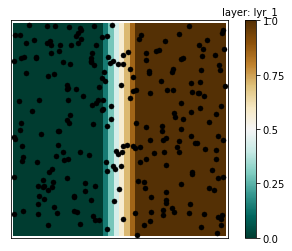

In [265]:
mod
mod.plot(spp=0, lyr=1)

<div class="alert alert-warning" role="alert" style="font-size:120%">
    <b><h2>Run the model</h2></b> 

Now we'll burn the model in, then see what we've got:



No mod.burn_fn_queue was found. Running mod.reset()...


Creating the burn-in function queue...


Creating the main function queue...


burn:	-1:0
	species: spp_0                         N=250	(births=34	deaths=0)

	........................................................................
burn:	-1:1
	species: spp_0                         N=284	(births=27	deaths=0)

	........................................................................
burn:	-1:2
	species: spp_0                         N=311	(births=41	deaths=0)

	........................................................................
burn:	-1:3
	species: spp_0                         N=352	(births=49	deaths=0)

	........................................................................
burn:	-1:4
	species: spp_0                         N=401	(births=54	deaths=1)

	........................................................................


/home/drew/Desktop/stuff/berk/research/projects/sim/geonomics/ops/demography.py:174: RuntimeWarning: divide by zero encountered in true_divide
  d = N_d/N
/home/drew/Desktop/stuff/berk/research/projects/sim/geonomics/ops/demography.py:174: RuntimeWarning: invalid value encountered in true_divide
  d = N_d/N


burn:	-1:5
	species: spp_0                         N=454	(births=66	deaths=2)

	........................................................................
burn:	-1:6
	species: spp_0                         N=518	(births=80	deaths=1)

	........................................................................
burn:	-1:7
	species: spp_0                         N=597	(births=74	deaths=7)

	........................................................................
burn:	-1:8
	species: spp_0                         N=664	(births=81	deaths=4)

	........................................................................
burn:	-1:9
	species: spp_0                         N=741	(births=108	deaths=13)

	........................................................................
burn:	-1:10
	species: spp_0                         N=836	(births=122	deaths=23)

	........................................................................
burn:	-1:11
	species: spp_0                         N=935	(births=127	deaths=

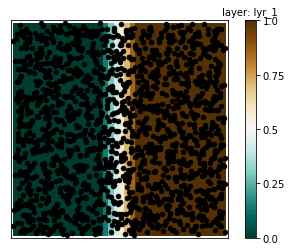

In [266]:
#SCROLL DOWN TO FOLLOW BURN-IN AND SEE PLOT

mod.walk(T=10000, mode='burn')
mod.plot(spp=0, lyr=1)

Then, before we start running the main section of the model, we can use a built-in Geonomics function to make a map of the individuals, colored by their phenotypes for the trait.

Note that the closer an individual's color is to its environmental background, the closer that individual is to the optimum phenotype for its location, and thus the higher the individual's fitness.

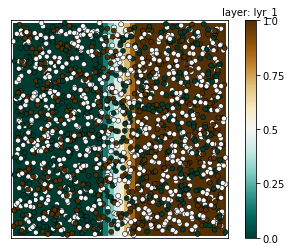

In [267]:
mod.plot_phenotype(spp=0, trait=0)

And let's also create our genetic relatedness plots again.

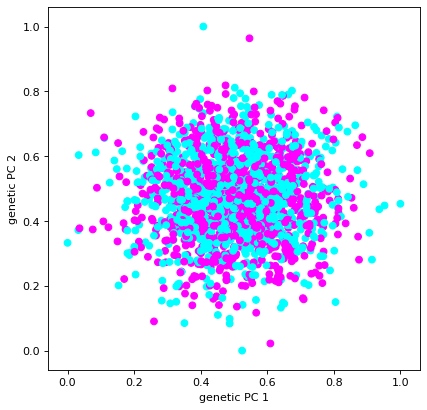

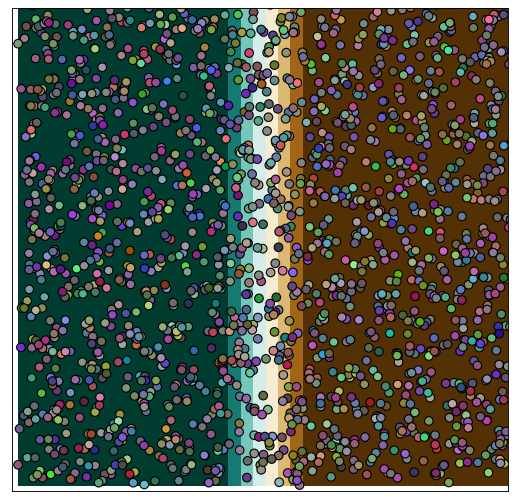

In [268]:
plot_PCA(mod)
map_PCA(mod, lyr_num=1, mask=False)

Now, let's run our model for 100 timesteps, then create our plots again, up until time step 300. Keep a close eye on all three plots, and think about why you see what you do.

In [269]:
mod.walk(50)



main:	-1:0
	species: spp_0                         N=1798	(births=251	deaths=258)

	........................................................................
main:	-1:1
	species: spp_0                         N=1791	(births=244	deaths=257)

	........................................................................
main:	-1:2
	species: spp_0                         N=1778	(births=258	deaths=292)

	........................................................................
main:	-1:3
	species: spp_0                         N=1744	(births=265	deaths=235)

	........................................................................
main:	-1:4
	species: spp_0                         N=1774	(births=241	deaths=297)

	........................................................................
main:	-1:5
	species: spp_0                         N=1718	(births=230	deaths=245)

	........................................................................
main:	-1:6
	species: spp_0                         N=170

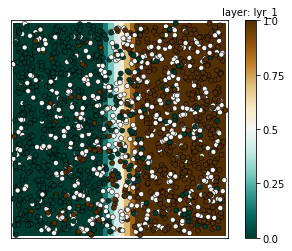

In [270]:
mod.plot_phenotype(spp=0, trait=0)

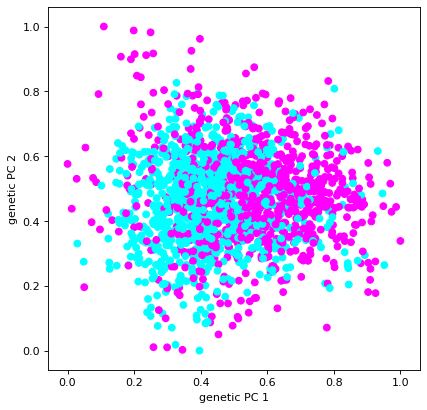

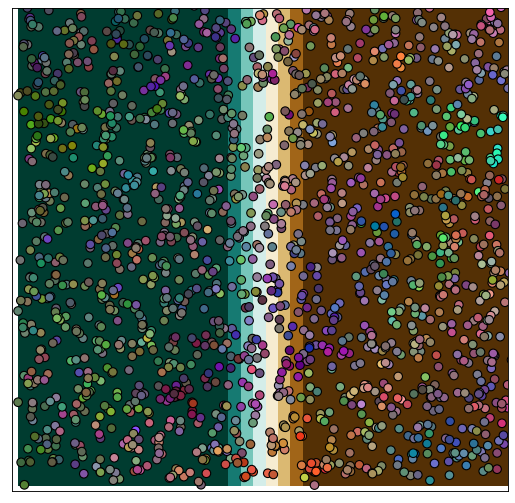

In [271]:
plot_PCA(mod)
map_PCA(mod, lyr_num=1, mask=False)

In [272]:
mod.walk(50)



main:	-1:50
	species: spp_0                         N=1728	(births=249	deaths=208)

	........................................................................
main:	-1:51
	species: spp_0                         N=1769	(births=230	deaths=260)

	........................................................................
main:	-1:52
	species: spp_0                         N=1739	(births=245	deaths=234)

	........................................................................
main:	-1:53
	species: spp_0                         N=1750	(births=230	deaths=240)

	........................................................................
main:	-1:54
	species: spp_0                         N=1740	(births=231	deaths=228)

	........................................................................
main:	-1:55
	species: spp_0                         N=1743	(births=219	deaths=204)

	........................................................................
main:	-1:56
	species: spp_0                       

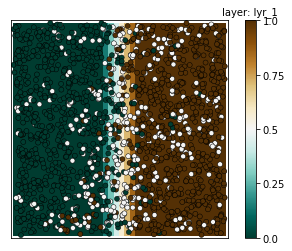

In [273]:
mod.plot_phenotype(spp=0, trait=0)

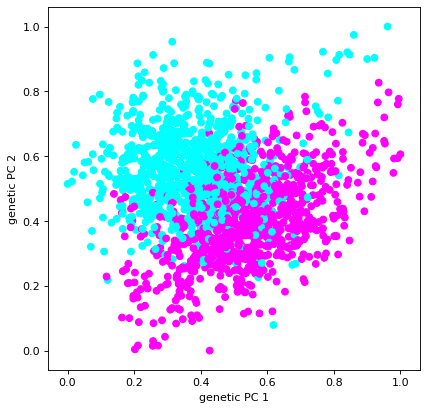

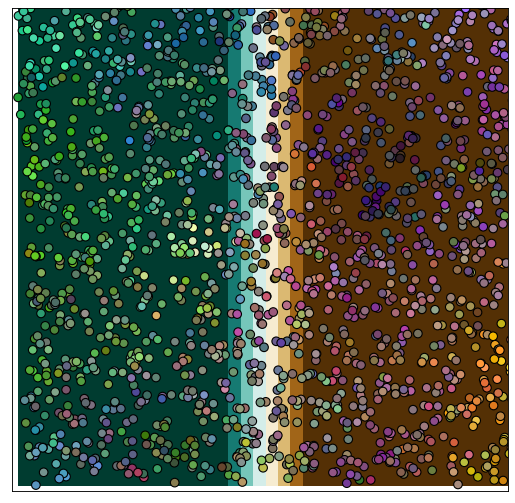

In [274]:
plot_PCA(mod)
map_PCA(mod, lyr_num=1, mask=False)

In [275]:
mod.walk(50)



main:	-1:100
	species: spp_0                         N=1776	(births=246	deaths=248)

	........................................................................
main:	-1:101
	species: spp_0                         N=1774	(births=244	deaths=258)

	........................................................................
main:	-1:102
	species: spp_0                         N=1760	(births=236	deaths=228)

	........................................................................
main:	-1:103
	species: spp_0                         N=1768	(births=243	deaths=246)

	........................................................................
main:	-1:104
	species: spp_0                         N=1765	(births=248	deaths=244)

	........................................................................
main:	-1:105
	species: spp_0                         N=1769	(births=225	deaths=262)

	........................................................................
main:	-1:106
	species: spp_0                

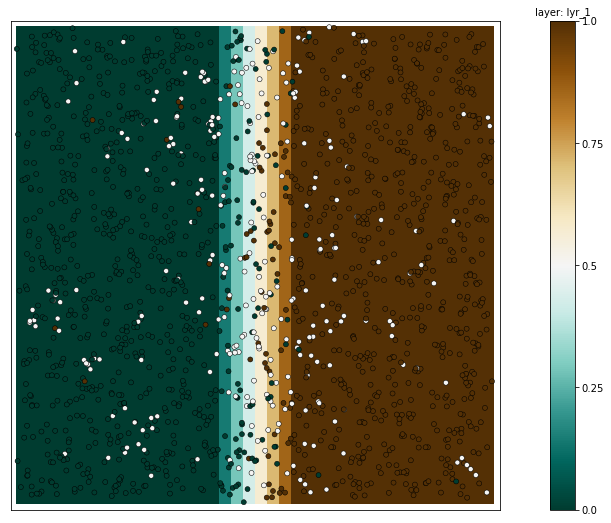

In [282]:
mod.plot_phenotype(spp=0, trait=0)

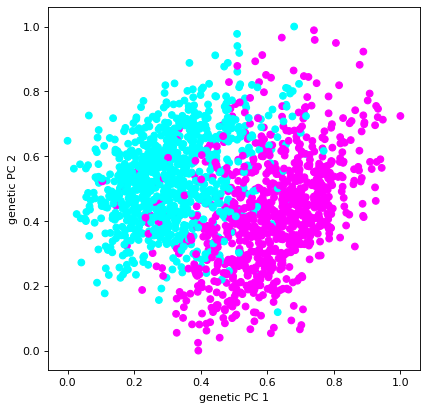

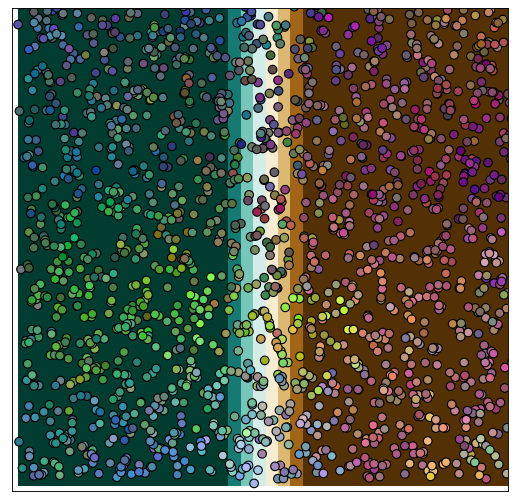

In [277]:
plot_PCA(mod)
map_PCA(mod, lyr_num=1, mask=False)

<div class="alert alert-warning" role="alert" style="font-size:120%">
    <b><h2>Tweak the model and rerun</h2></b> 

In the remaining time, go back and <u>create your own scenario, by changing one or more of the following parameters</u> as you wish:

- **phi** parameter: *This controls the strength of selection on the trait. It can be set to 0 <= value <= 1.*

- **n_loci** parameter: *This controls the number of genetic loci underlying the trait's phenotype. For this simulation, it can be set to 1 <= value <= 100.*

- **K_factor** parameter: *This controls the population density, by setting the number of individuals that can inhabit each cell. It can be set to any value > 0, technically, but values larger than 3 or 4 will probably require too much memory to run on this server, so be careful!*

- **distance_dist_mu** parameter: *This controls the average distance that an individual moves each time step (in units of cell-widths), and thus how mobile the species is. For this simulation, it can be set to any value > 0 (but very large values might cause problems!).*

- **mating_radius** parameter: *This controls the radius (expressed in cell-width units) within which an indivudal can choose a mate. For this simulation, it can be set to any value > 0.*

If you wish, you should feel free to also toy with any other parameters. But please know that by doing so you may break the code and be unable to run your simulation.

Once you've made your desired changes, <u>rerun the code above</u>, and make observations about the effect of the change you made.